In [1]:
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
mpl.rcParams["image.cmap"] = "Blues"
mpl.rcParams["figure.dpi"] = 100

import os
import numpy as np

import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
inputdir_ele = "/work/dvalsecc/Clustering/dataset/electrons_awkward_2022v4/"
inputdir_gamma = "/work/dvalsecc/Clustering/dataset/gammas_awkward_2022v4/"

In [3]:
cols = ["cl_features", "cl_labels", "window_features", "window_metadata", "cl_h"]
df_ele = ak.from_parquet(inputdir_ele, lazy=True, use_threads=True, columns=cols)
df_gamma = ak.from_parquet(inputdir_gamma, lazy=True, use_threads=True, columns=cols)

# Training dataset preparation

In [4]:
from itertools import zip_longest, islice
from collections import deque

def load_dataset_chunks(df, chunk_size, tot,  config, offset=0):
    # Filtering the columns to keey only the requested ones
    cols = { key: df[key][v] for key, v in config["columns"].items() }
    # Adding the clusters hits 
    if config["read_hits"]:
        cols['cl_h'] = df.cl_h
    filtered_df = ak.zip(cols, depth_limit=1)
    # Now load in large chunks batching
    nchunks = tot//chunk_size
    for i in range(nchunks):
        # Then materialize it
        yield chunk_size, ak.materialized(filtered_df[offset + i*chunk_size: offset + (i+1)*chunk_size])
        #yield batch_size, df[i*batch_size: (i+1)*batch_size]
        
def split_batches(gen, batch_size):
    for size, df in gen:
        if size % batch_size == 0:
            for i in range(size//batch_size):
                if isinstance(df, tuple):
                    yield batch_size, tuple(d[i*batch_size : (i+1)*batch_size] for d in df)
                else:
                    yield batch_size, df[i*batch_size : (i+1)*batch_size]
        else:
            raise Exception("Please specifie a batchsize compatible with the loaded chunks size")
        
def buffer(gen,size):
    ''' This generator buffer a number `size` of elements from an iterator and yields them. 
    When the buffer is empty the quee is filled again'''
    q = deque()
    while True:
        # Caching in the the queue some number of elements
        in_q = 0
        try:
            for _ in range(size):
                q.append(next(gen))
                in_q +=1
        except StopIteration:
            for _ in range(in_q):
                yield q.popleft()
            break
        # Now serve them
        for _ in range(in_q):
            yield q.popleft()
        
def shuffle_fn(size, df):
    try:
        perm_i = np.random.permutation(size)
        return size, df[perm_i]
    except:
        return 0, ak.Array([])
    
    
def shuffle_dataset(gen, n_batches=None):
    if n_batches==None: 
        # permute the single batch
        for i, (size, df) in enumerate(gen):
            yield shuffle_fn(size, df)
    else:
        for dflist in cache_generator(gen, n_batches):
            size = dflist[0][0] 
            perm_i = np.random.permutation(size*len(dflist))
            totdf = ak.concatenate([df[1] for df in dflist])[perm_i]
            for i in range(n_batches):
                yield size, totdf[i*size: (i+1)*size]
                
def zip_datasets(*iterables):
    yield from zip_longest(*iterables, fillvalue=(0, ak.Array([])))
    
def concat_fn(dfs):
    return sum([d[0] for d in dfs]), ak.concatenate([d[1] for d in dfs])

def concat_datasets(*iterables):
    for dfs in zip_datasets(*iterables):
        yield concat_fn(dfs)
    

In [5]:
import multiprocessing as mp

def multiprocessor_generator(iterable, heavy_processing, input_queue_size=10, output_queue_size=20, nworkers=2):
    def gen_to_queue(input_q, iterable):
        # This function simply consume our generator and write it to the input queue
        for it in iterable:
            input_q.put(it)
        for _ in range(nworkers):    # Once generator is consumed, send end-signal
            input_q.put(None)

    def process(input_q, output_q):
        # Change the random seed for each processor
        pid = mp.current_process().pid
        np.random.seed()
        while True:
            it = input_q.get()
            if it is None:
                output_q.put(None)
                break
            output_q.put(heavy_processing(it))
    
    input_q = mp.Queue(maxsize=input_queue_size)
    output_q = mp.Queue(maxsize=output_queue_size)

    # Here we need 3 groups of worker :
    # * One that will consume the input generator and put it into a queue. It will be `gen_pool`. It's ok to have only 1 process doing this, since this is a very light task
    # * One that do the main processing. It will be `pool`.
    # * One that read the results and yield it back, to keep it as a generator. The main thread will do it.
    gen_pool = mp.Pool(1, initializer=gen_to_queue, initargs=(input_q, iterable))
    pool = mp.Pool(nworkers, initializer=process, initargs=(input_q, output_q))
    
    
    try : 
        finished_workers = 0
        while True:
            it = output_q.get()
            if it is None:
                finished_workers += 1
                if finished_workers == nworkers:
                    break
            else:
                yield it
    finally: 
        # This is called at GeneratorExit
        gen_pool.close()
        pool.close()
            
    

### Plotting example

In [ ]:
def plot_window_rechits(df):
    d = 5
    xmin = ak.min(df[:,:,1])-d
    xmax = ak.max(df[:,:,1])+d
    ymin = ak.min(df[:,:,0])-d
    ymax = ak.max(df[:,:,0])+d
    plt.hist2d(ak.flatten(df[:,:,1]), ak.flatten(df[:,:,0]), weights=ak.flatten(df[:,:,3]), range=((xmin, xmax), (ymin, ymax)), bins=(int(xmax-xmin), int(ymax-ymin)), norm=LogNorm(), cmap="viridis")
    plt.ylabel("ieta")
    plt.xlabel("iphi")
    plt.colorbar(label="Rechit Energy [GeV]")
    plt.show()

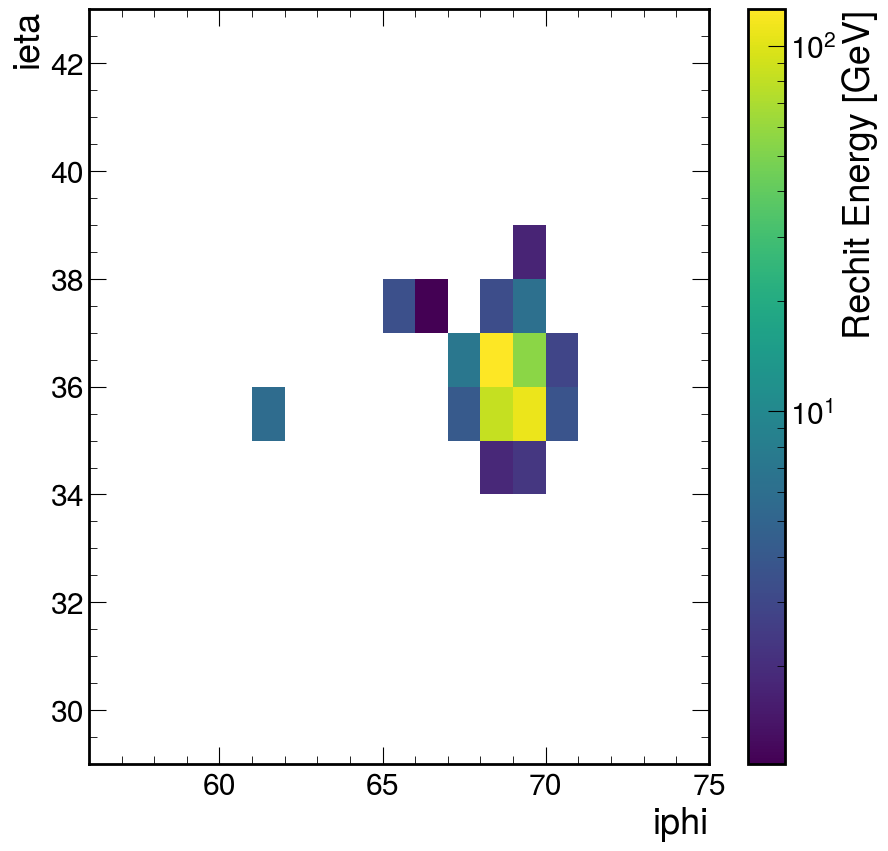

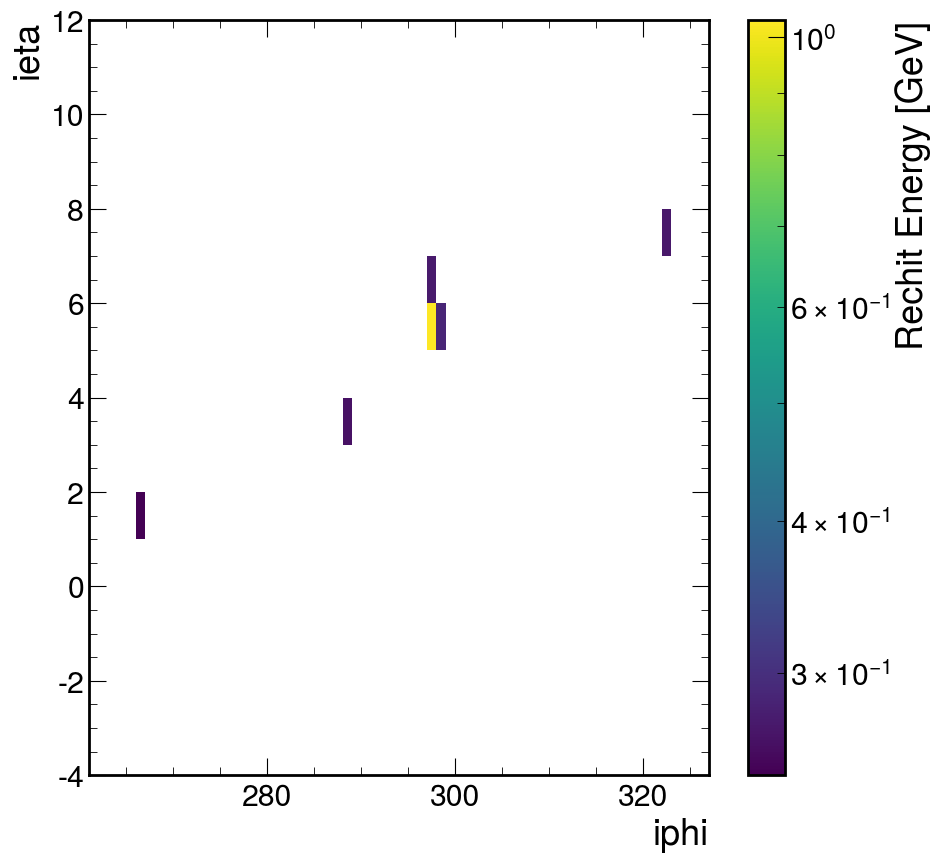

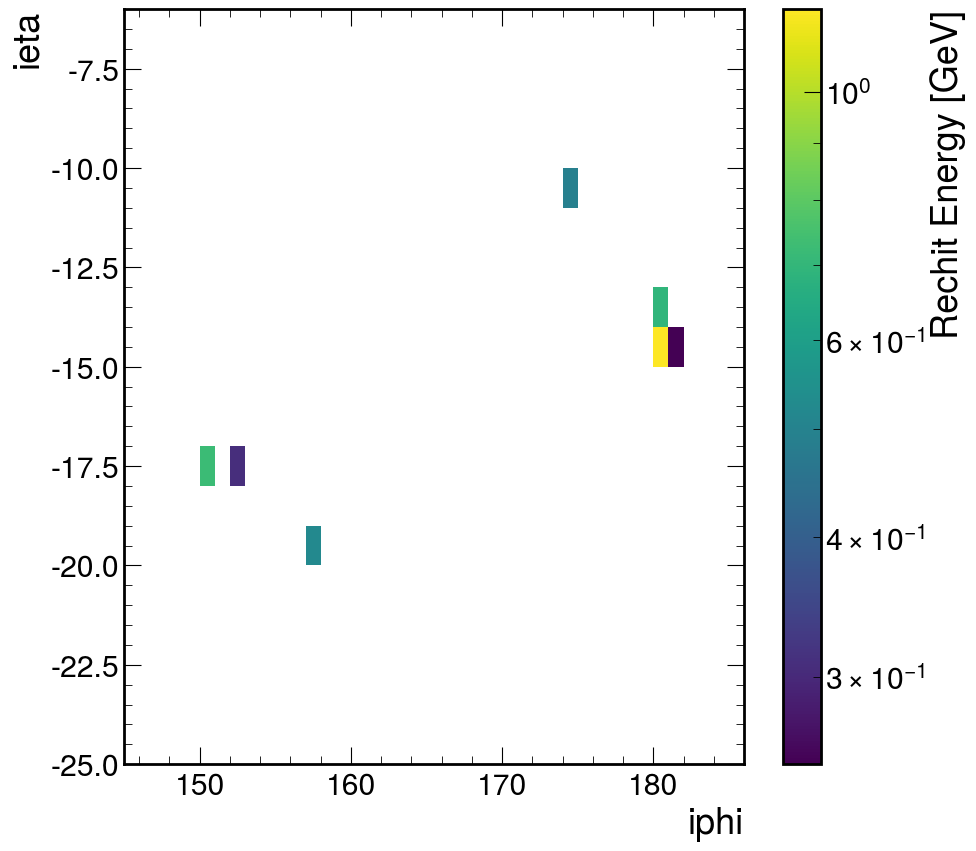

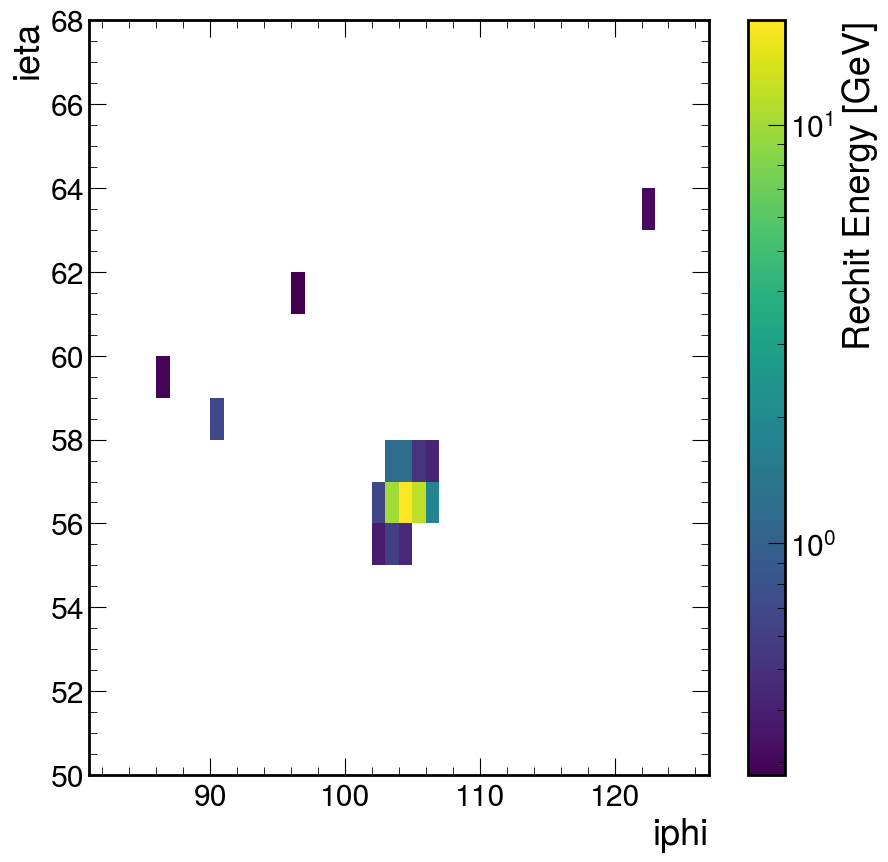

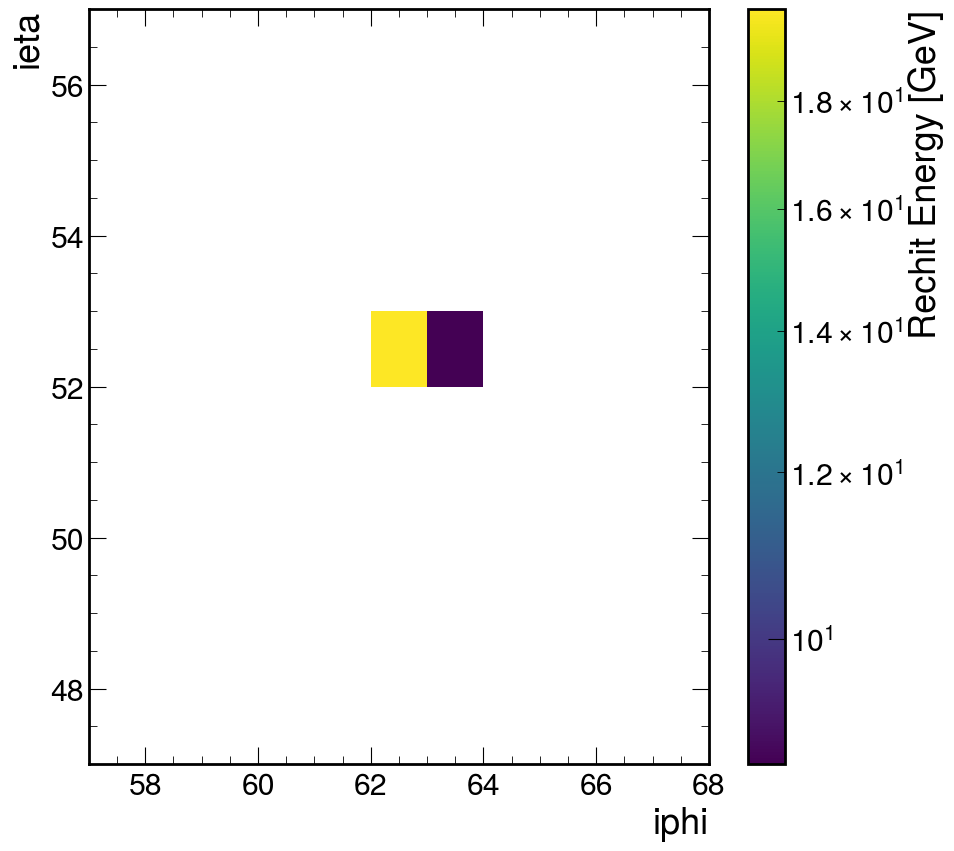

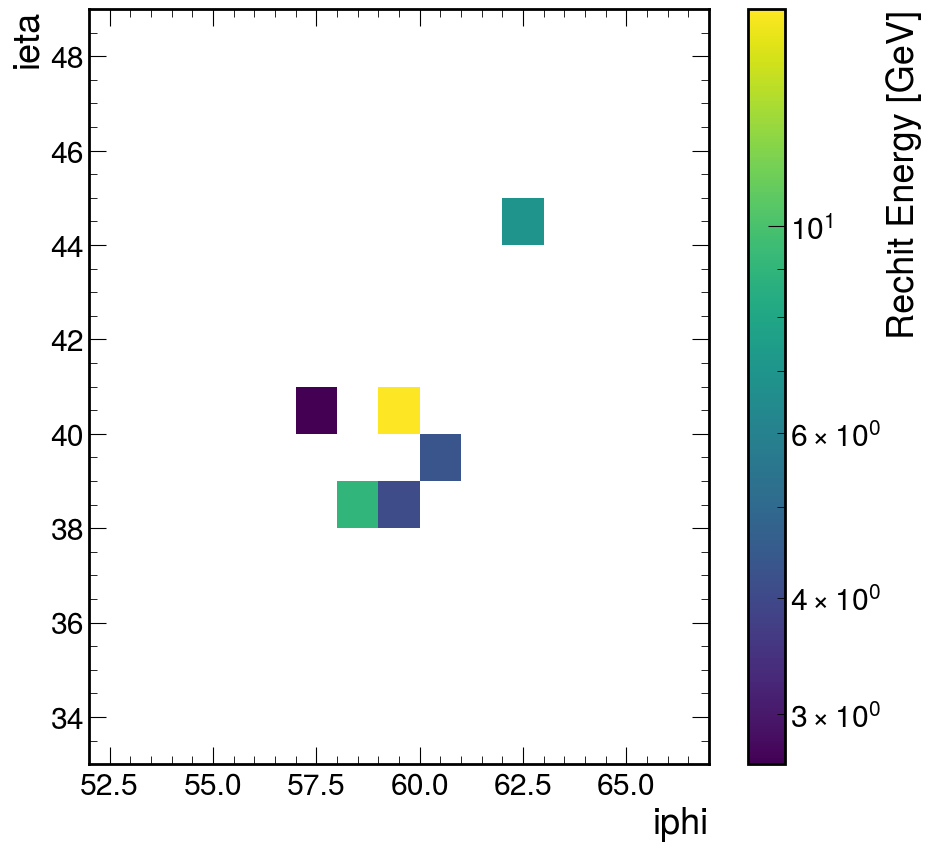

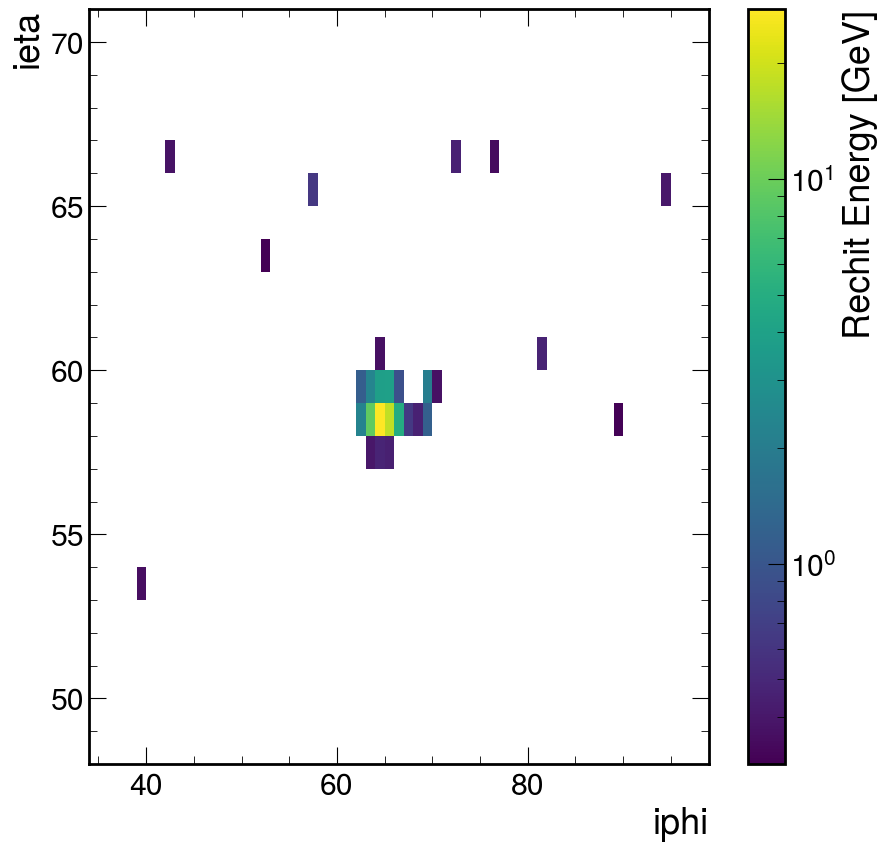

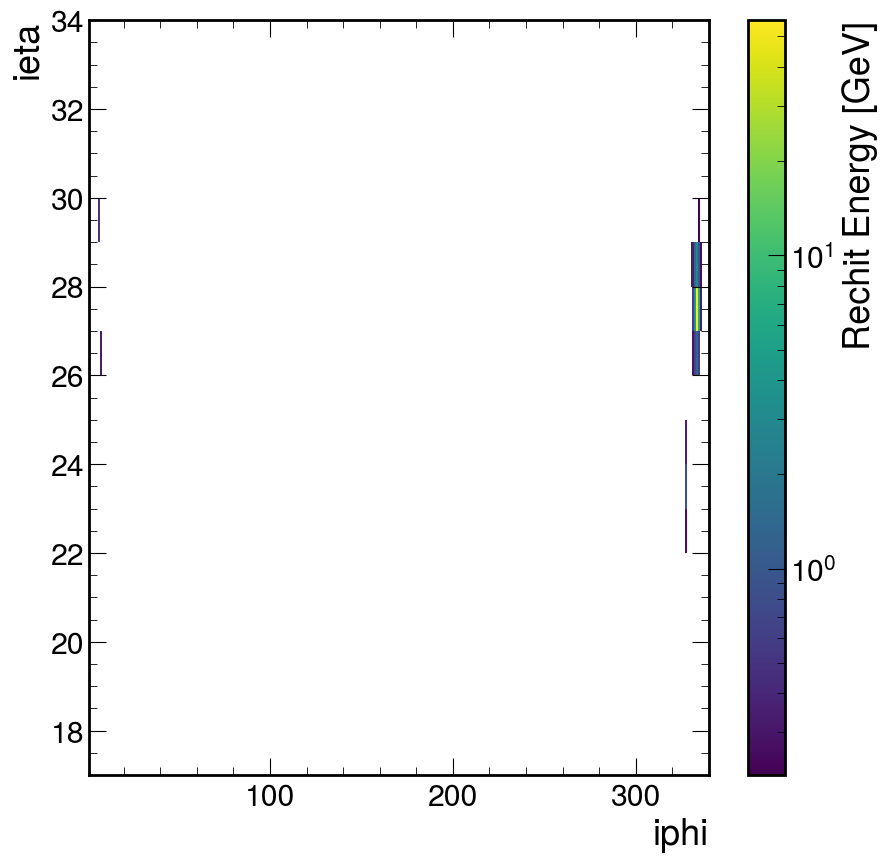

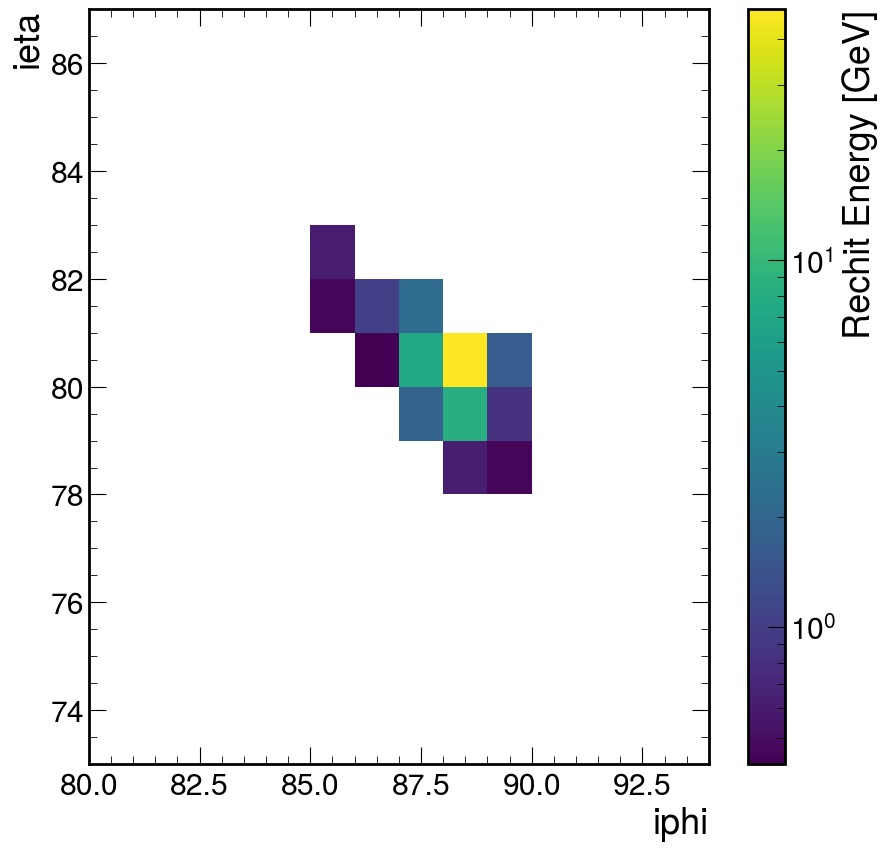

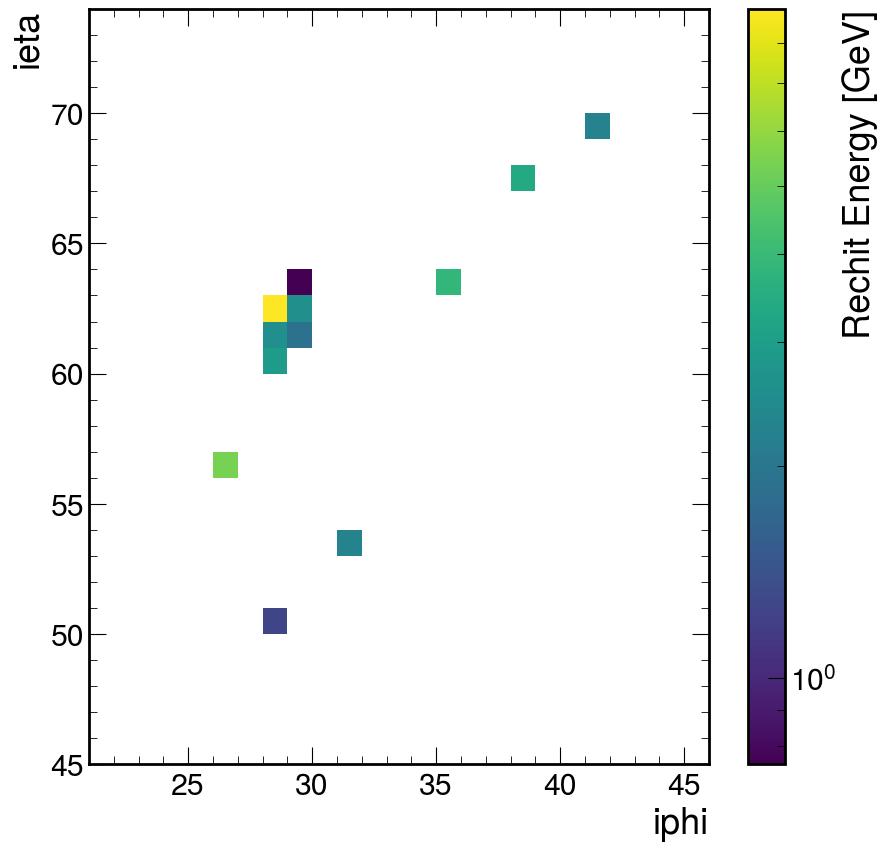

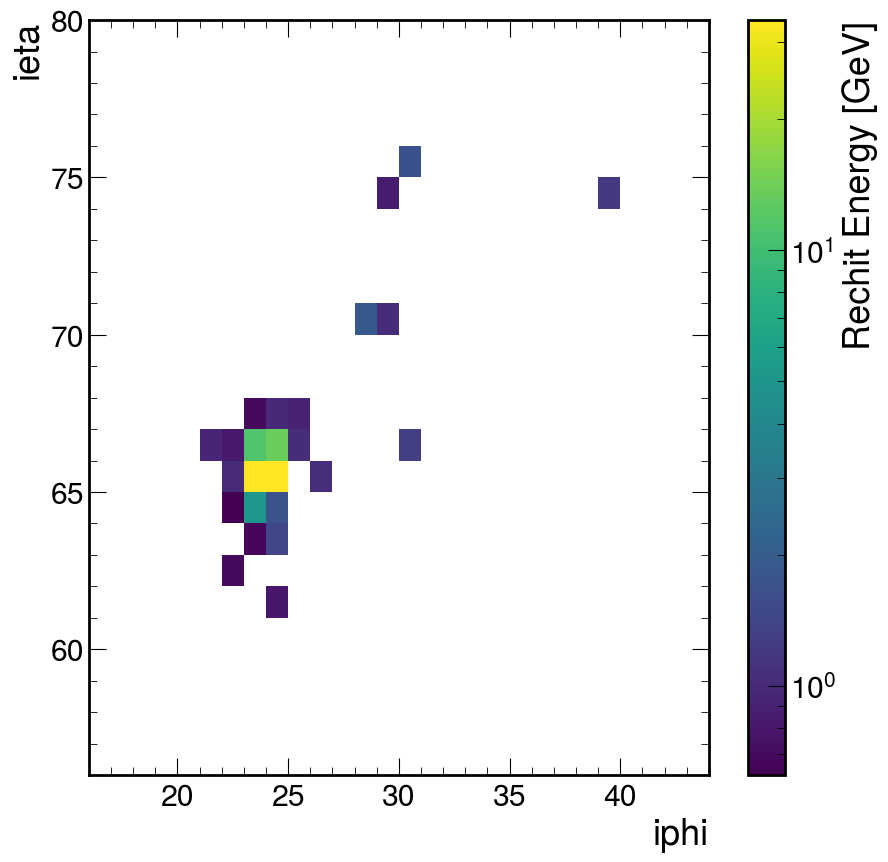

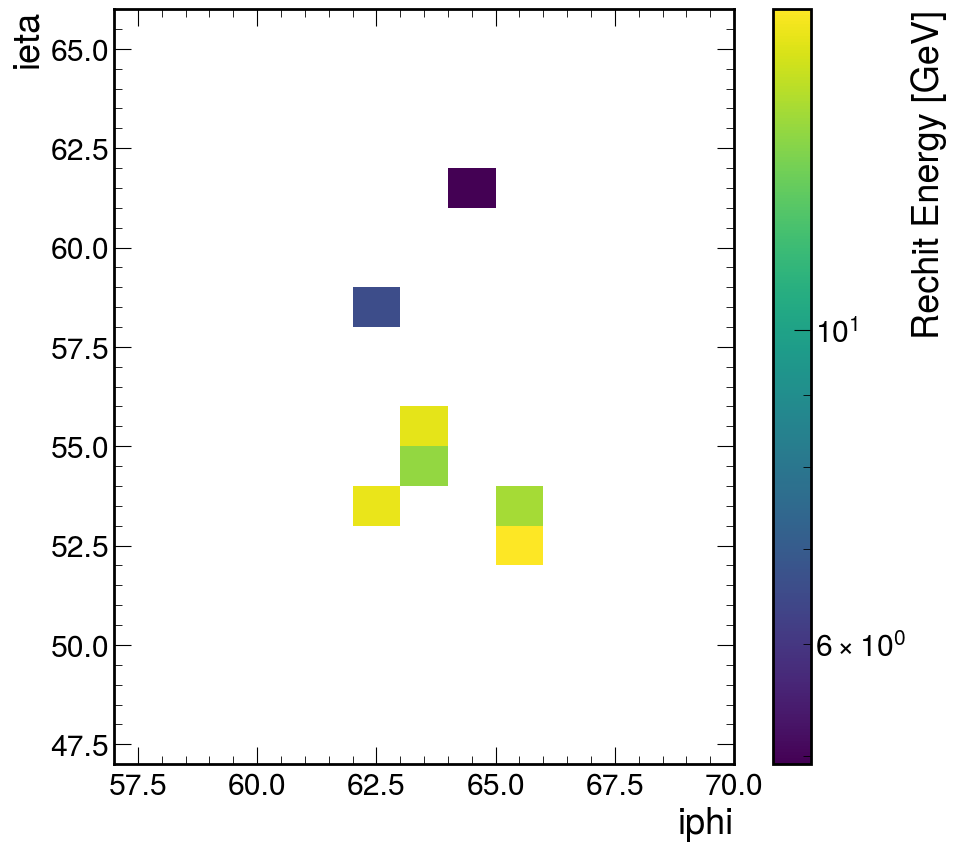

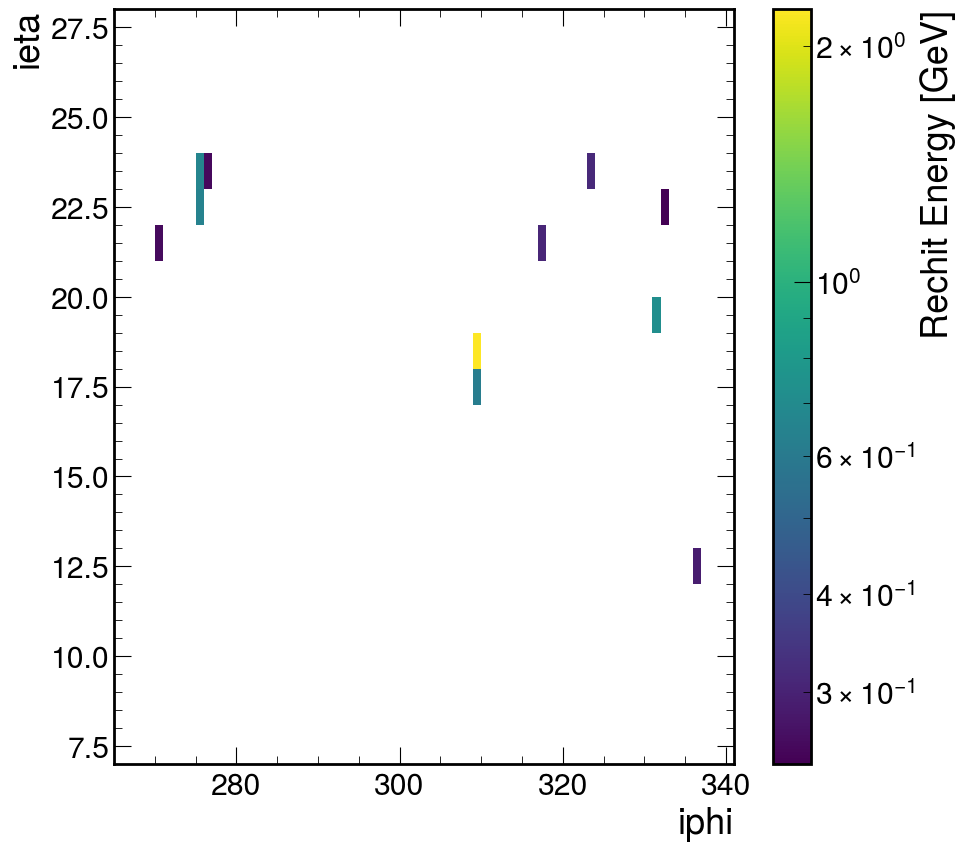

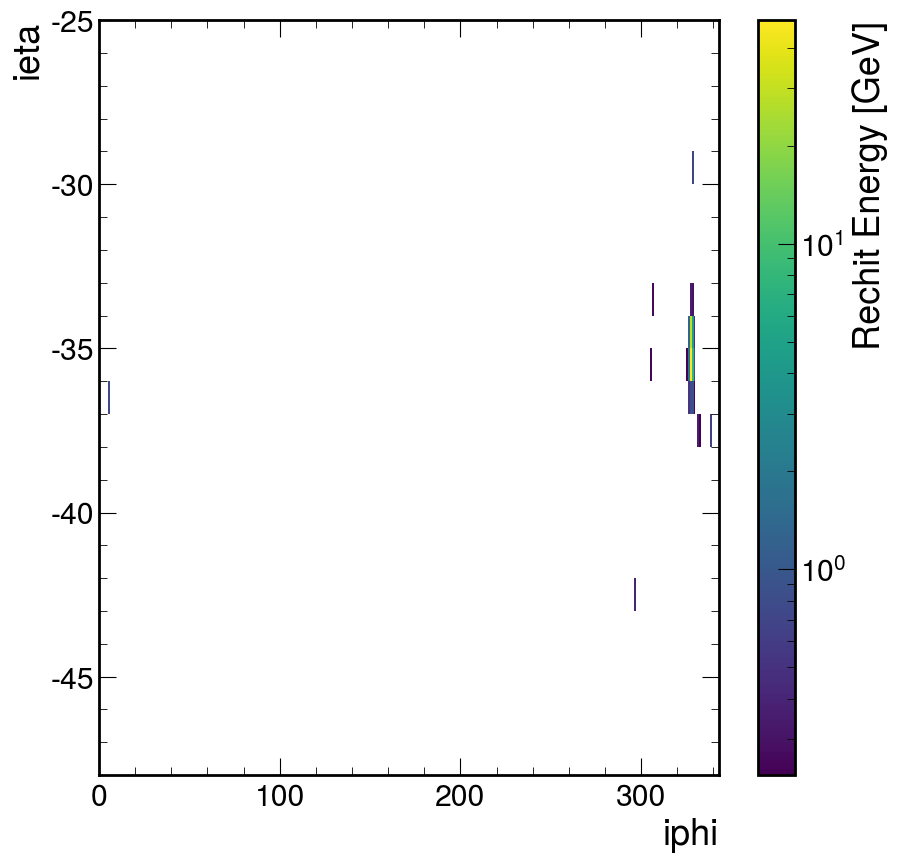

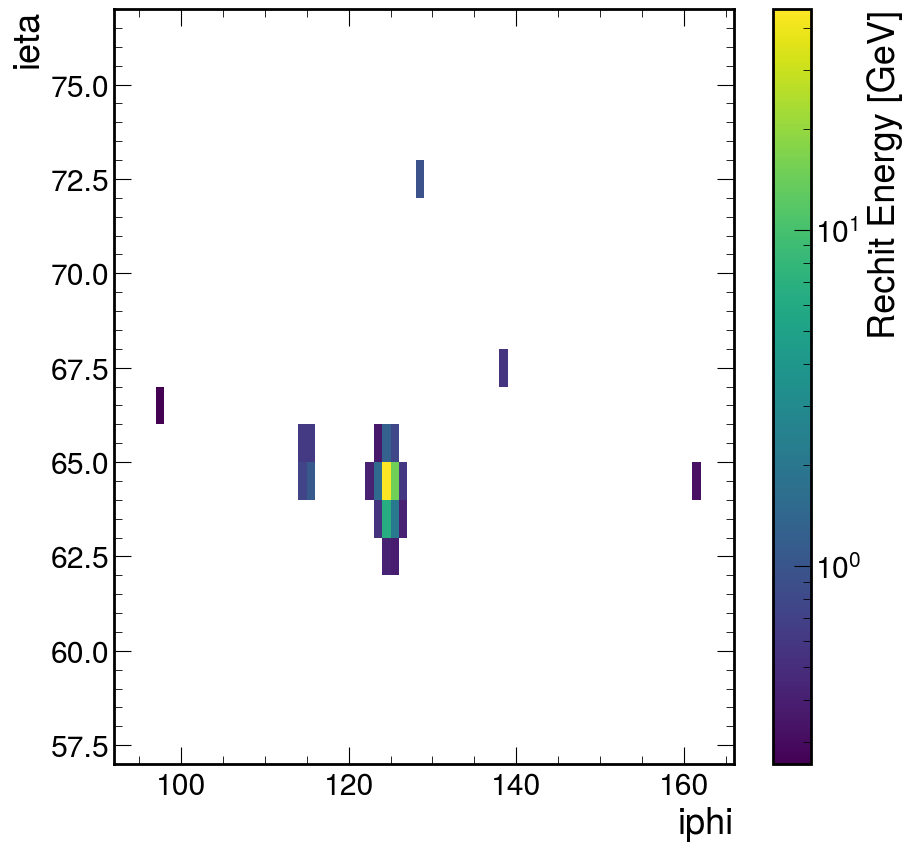

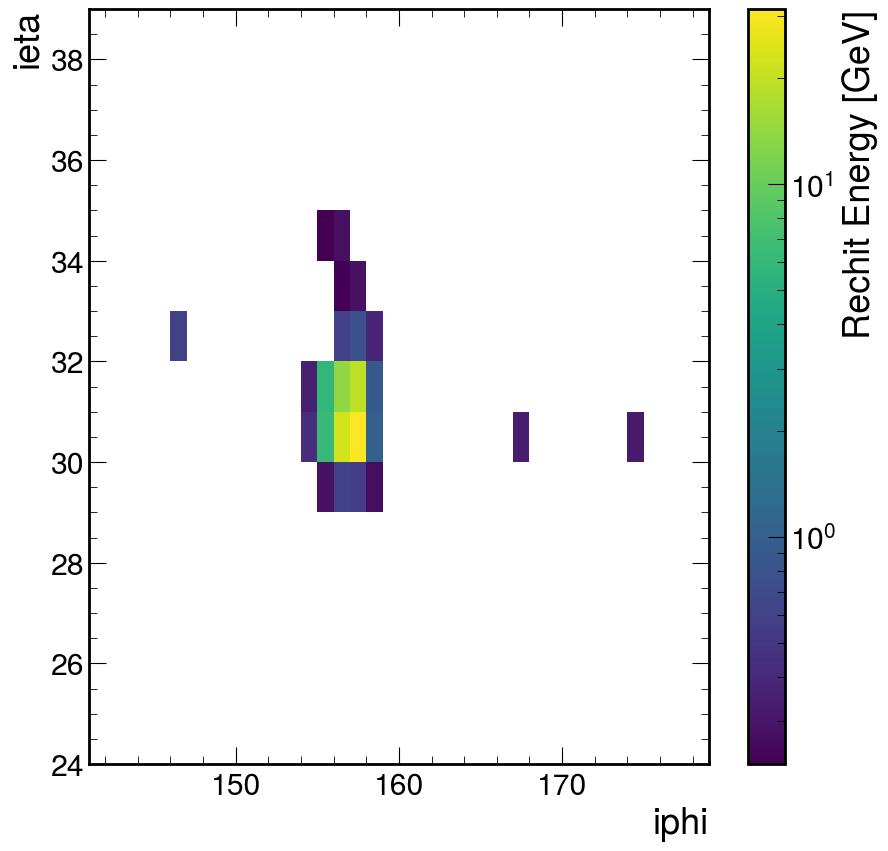

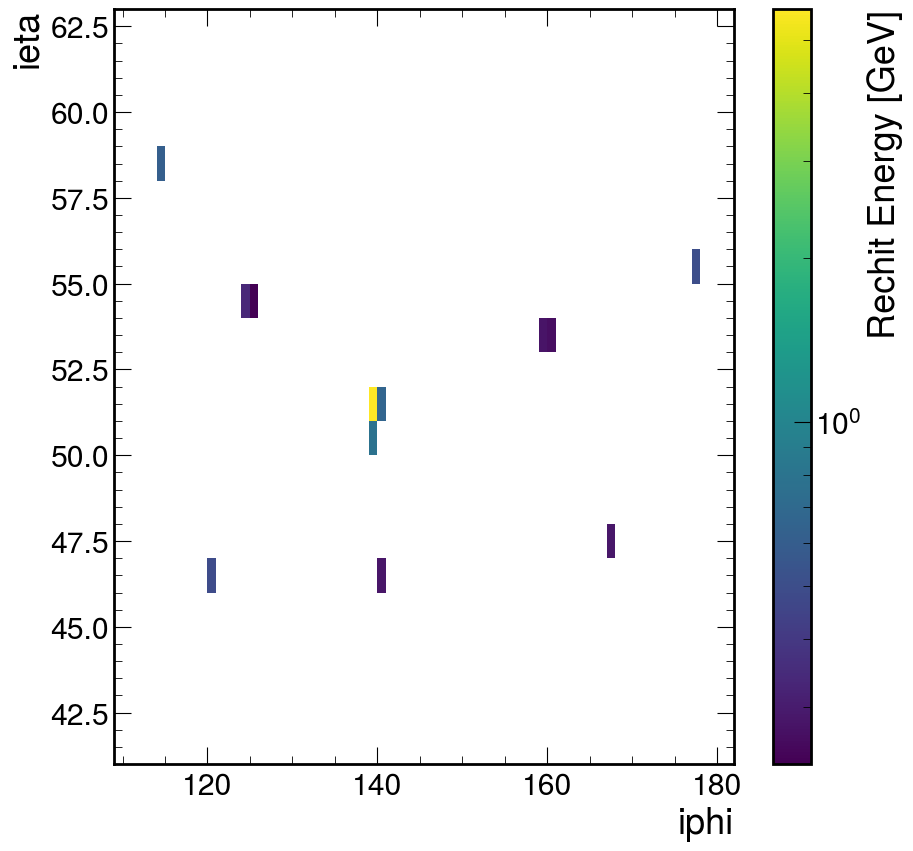

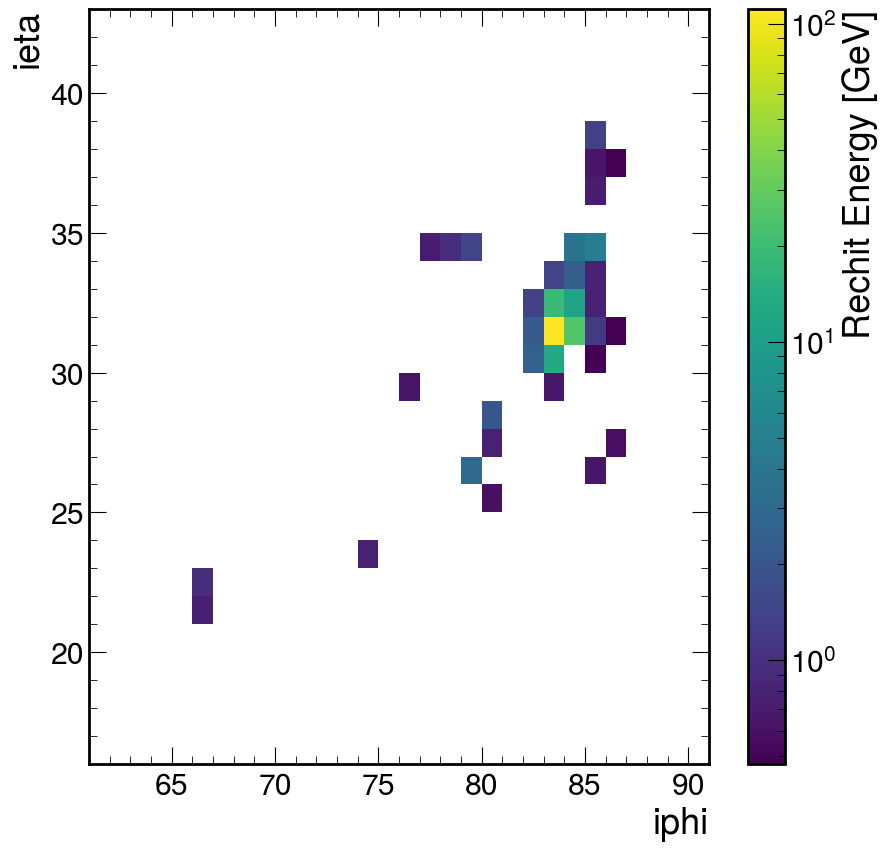

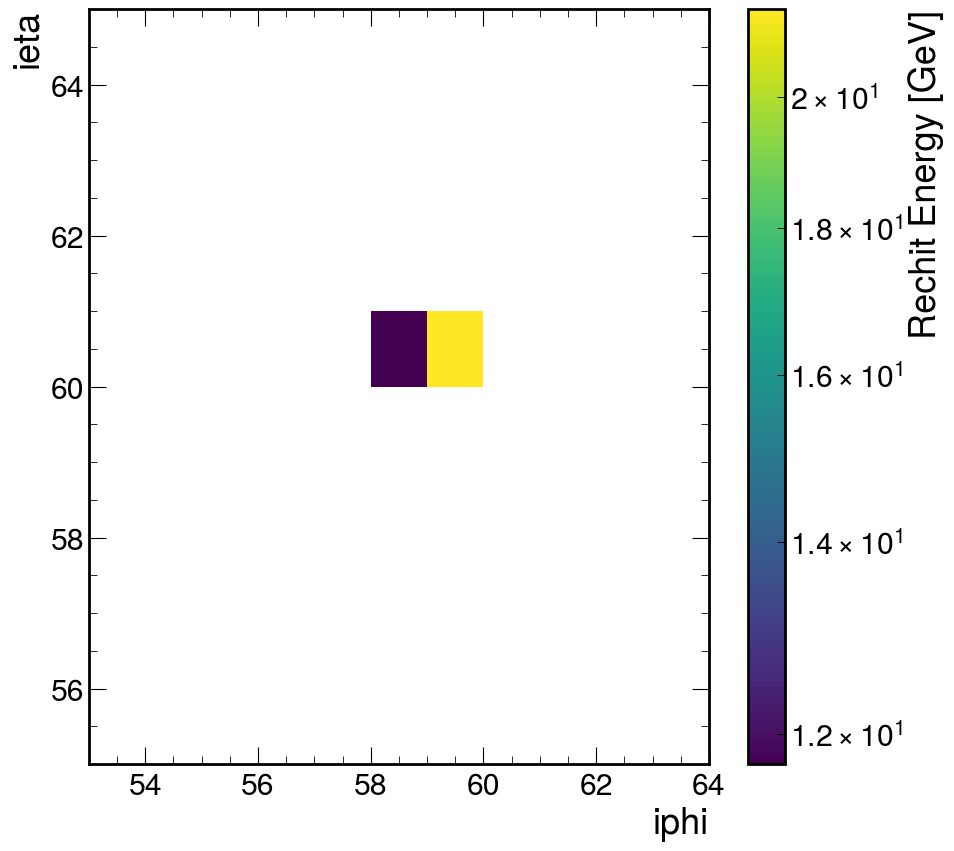

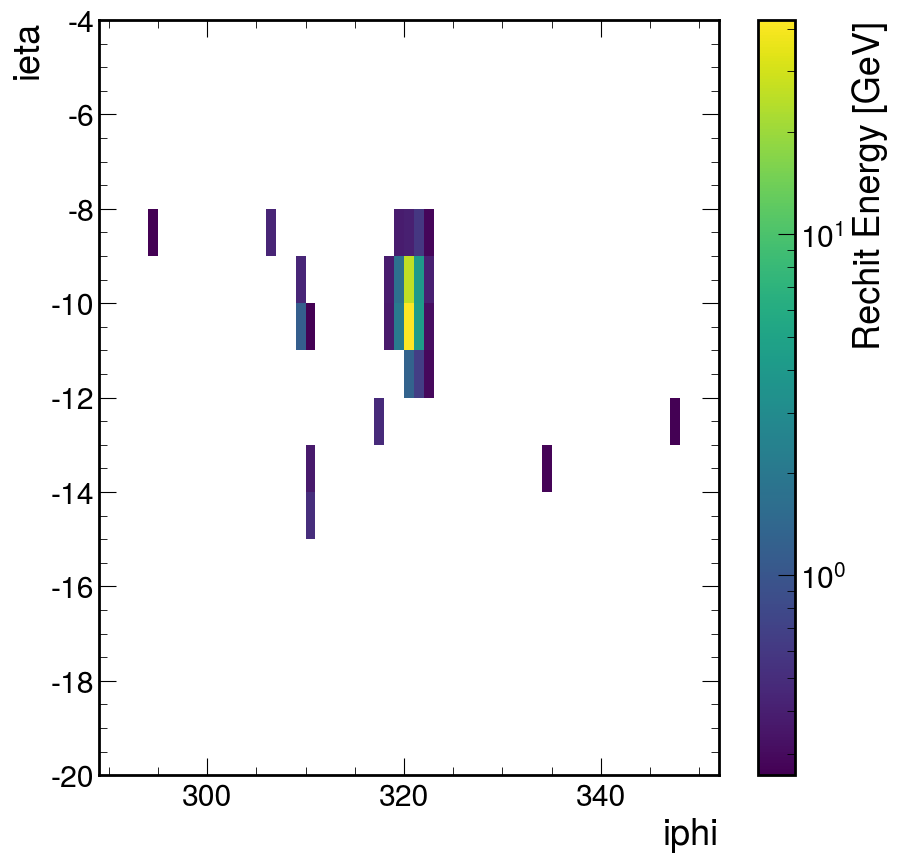

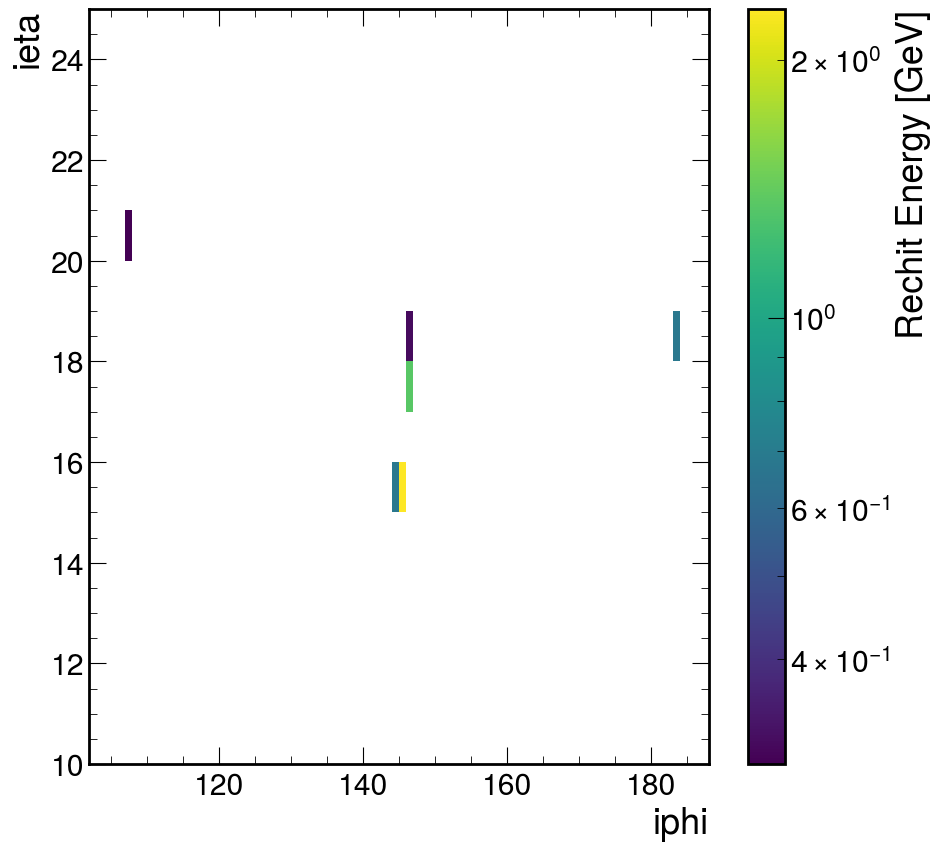

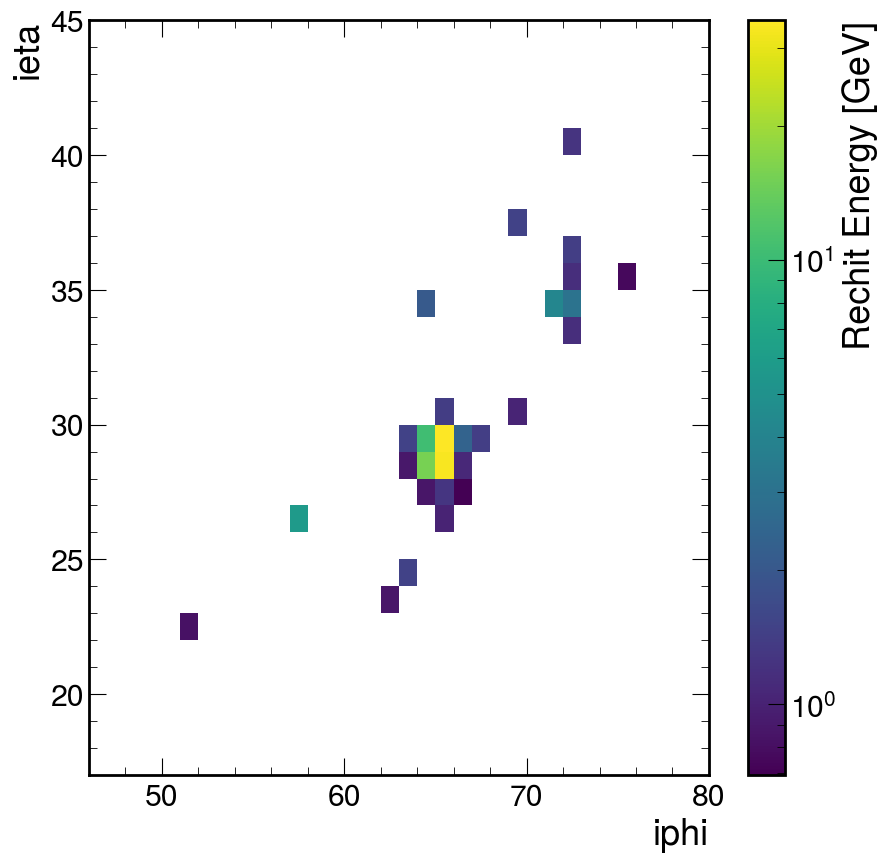

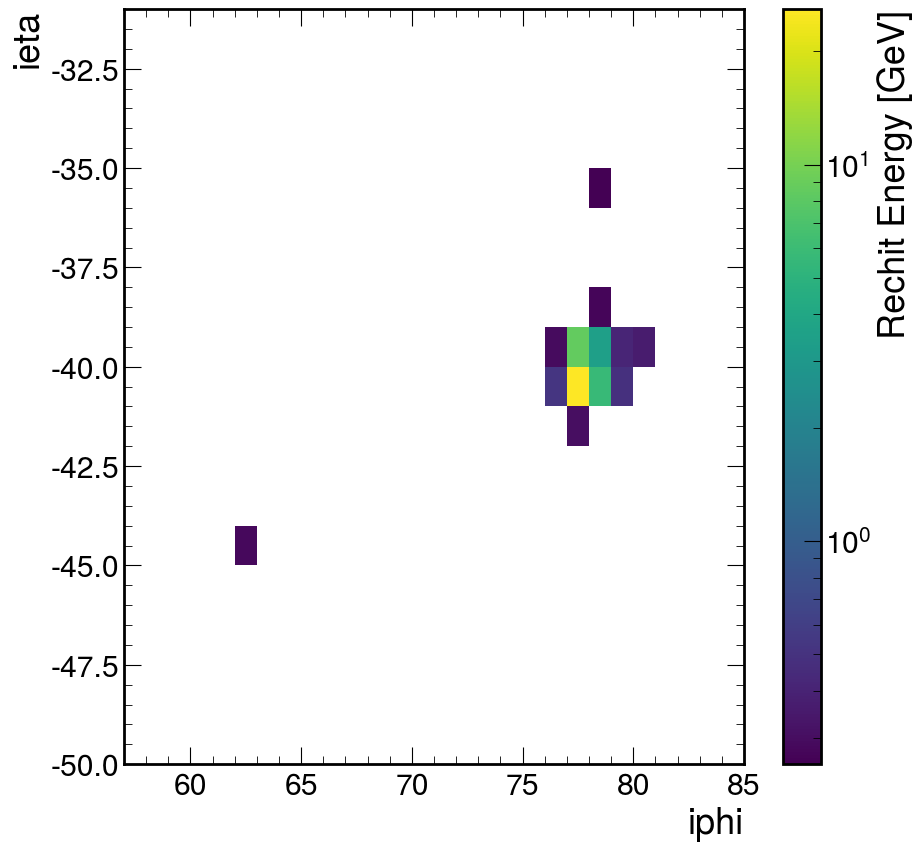

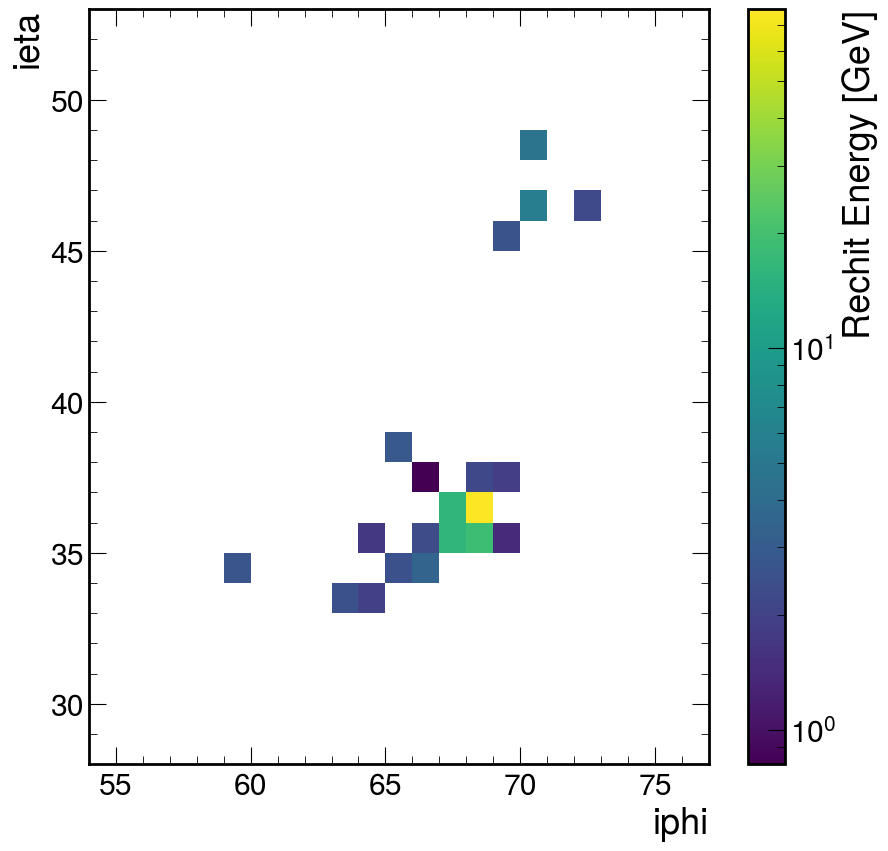

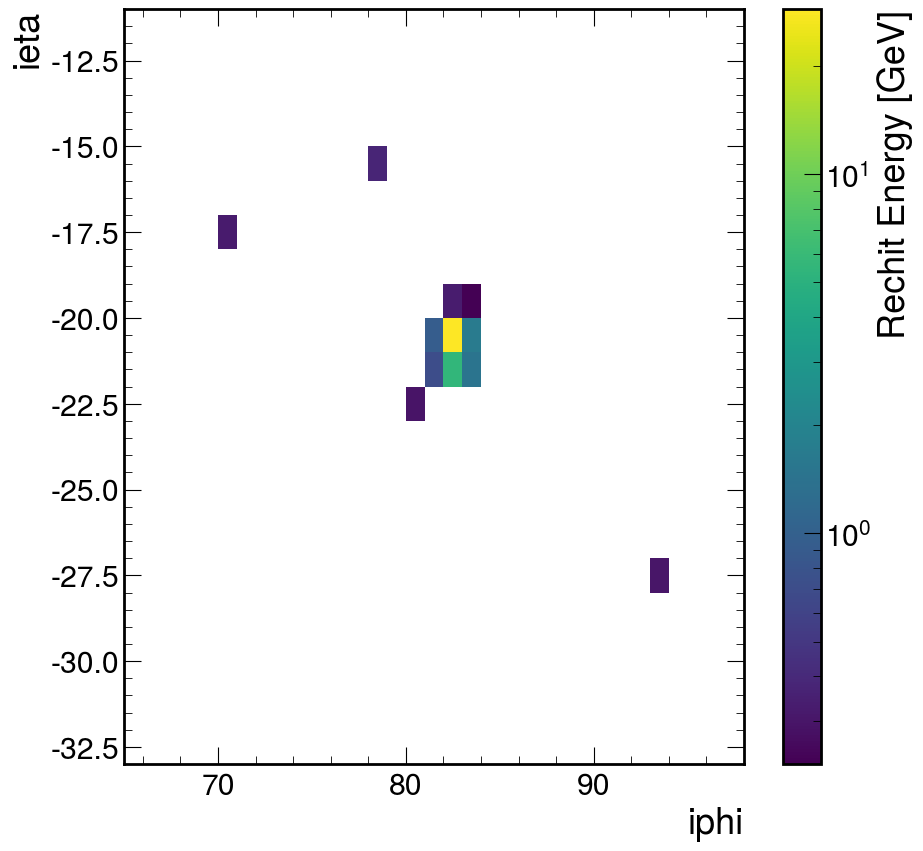

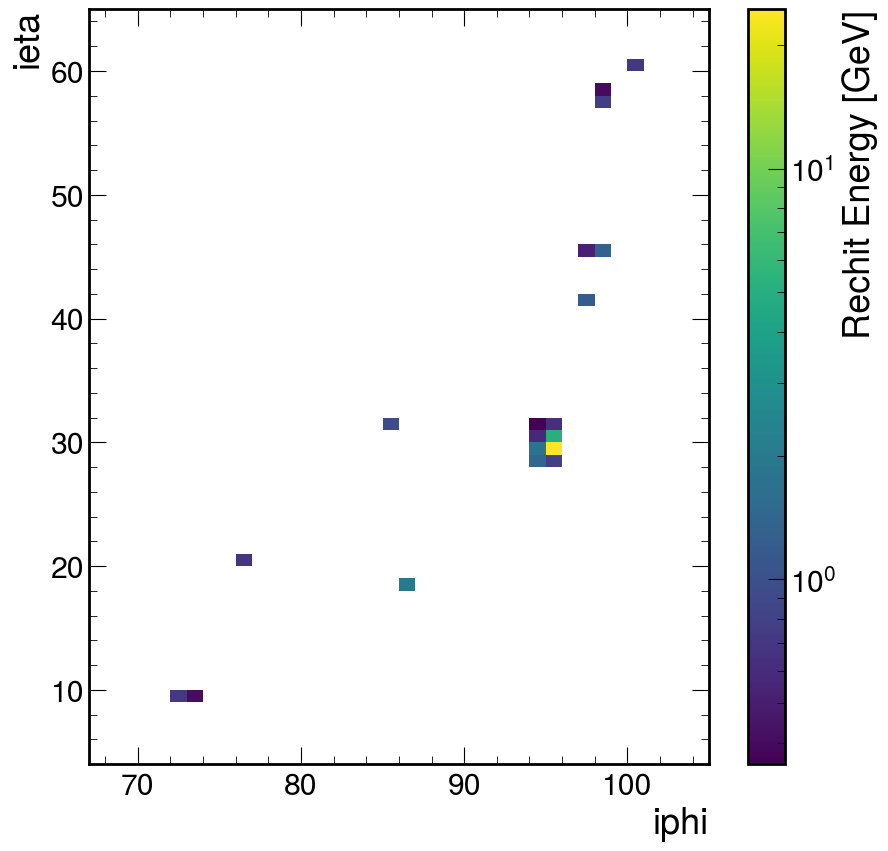

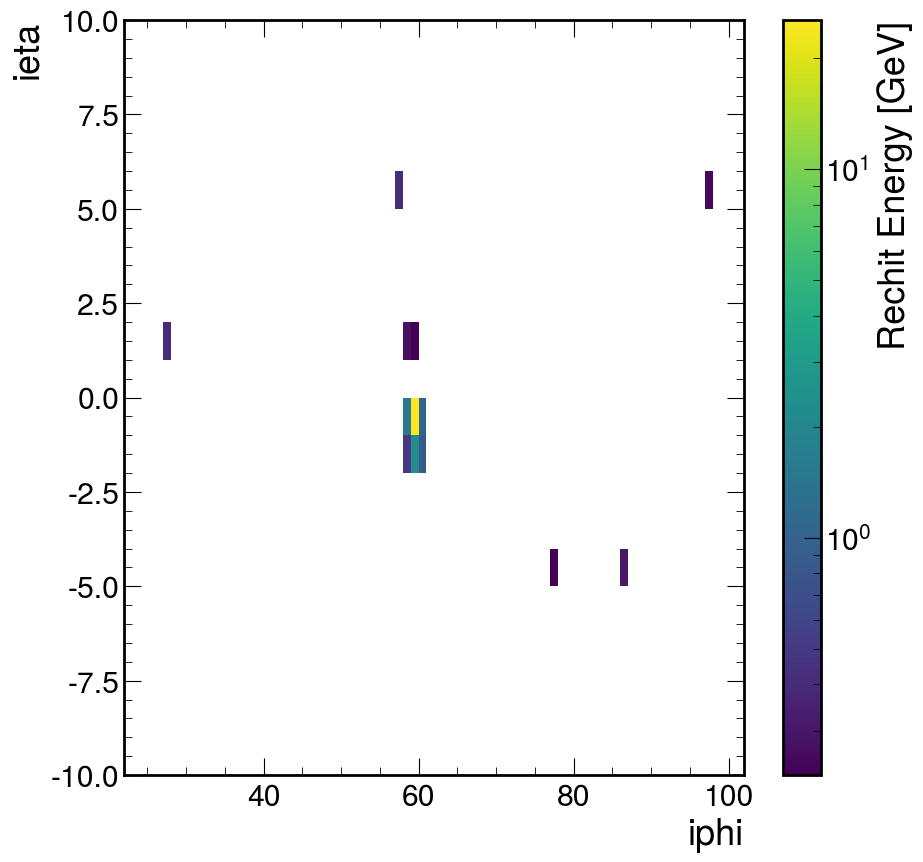

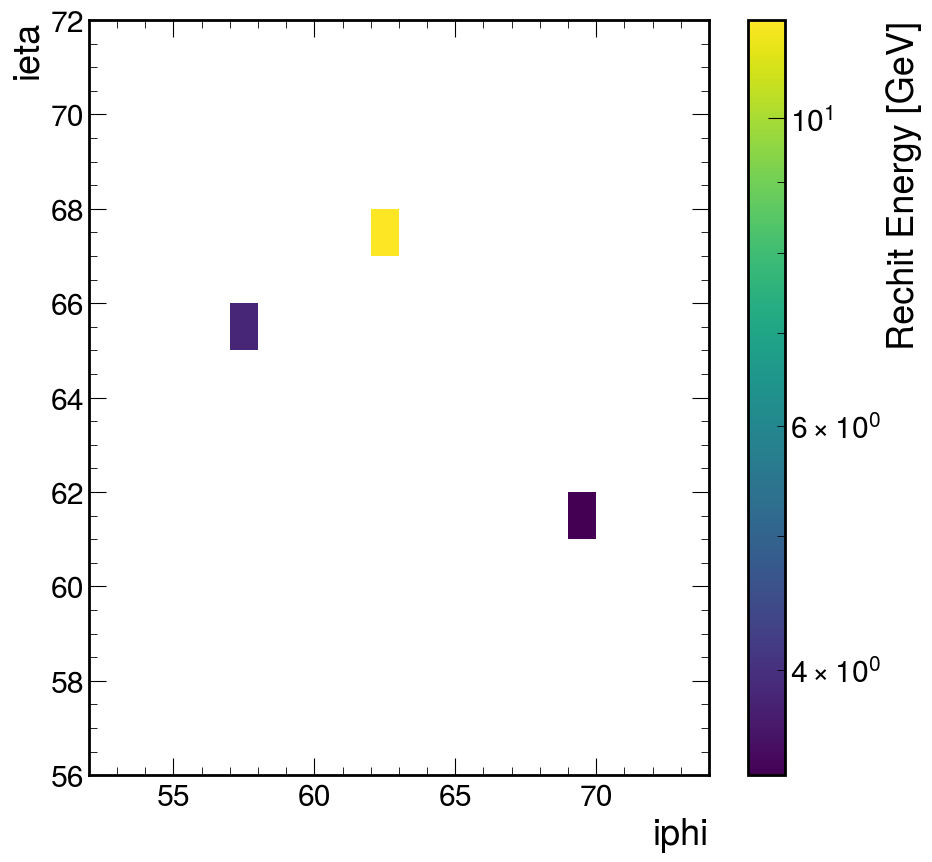

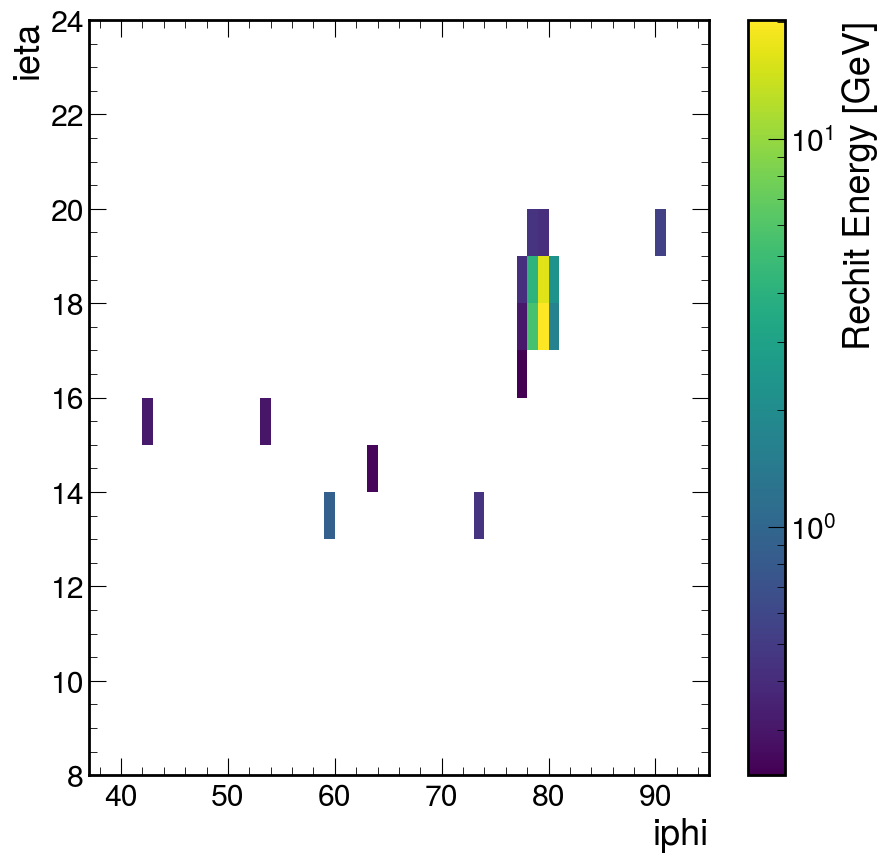

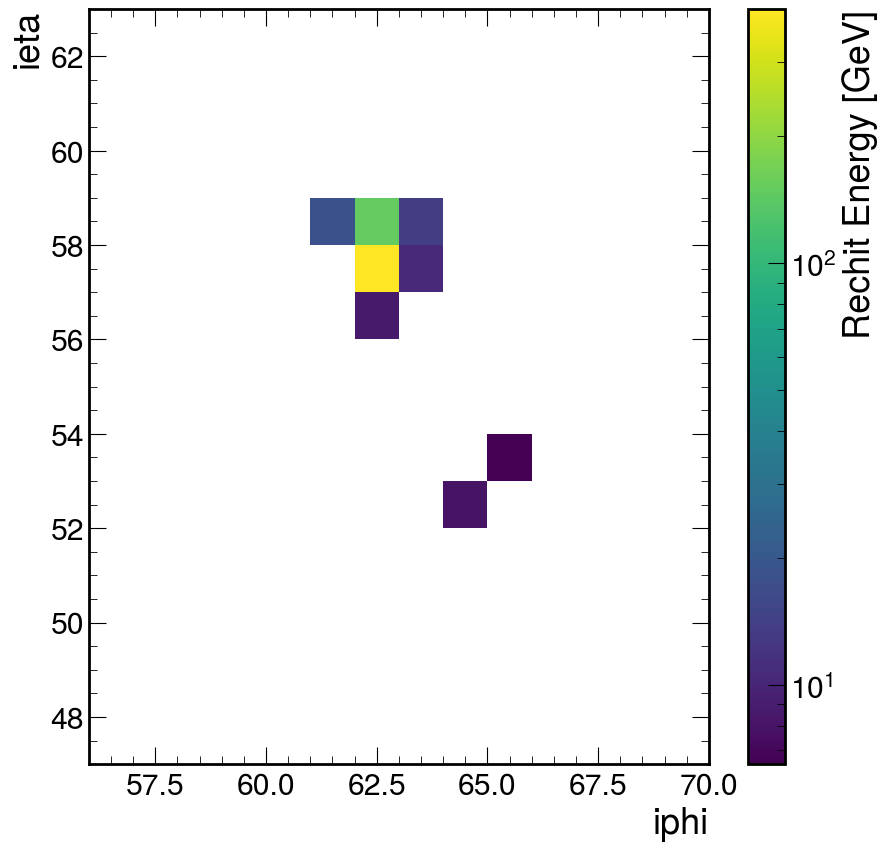

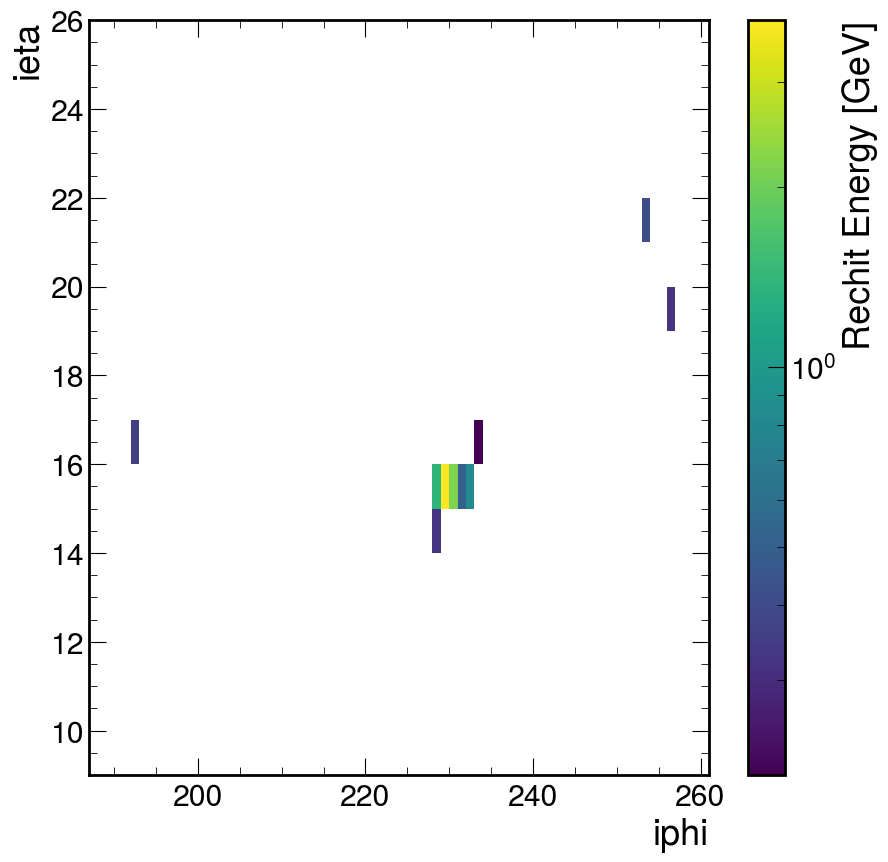

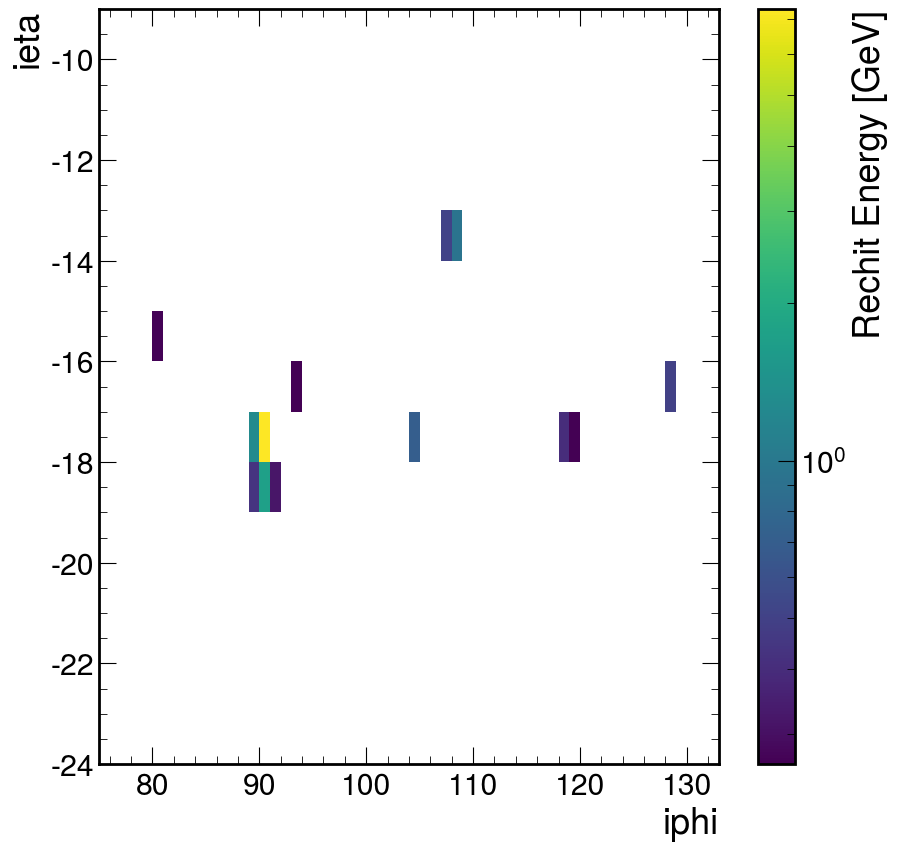

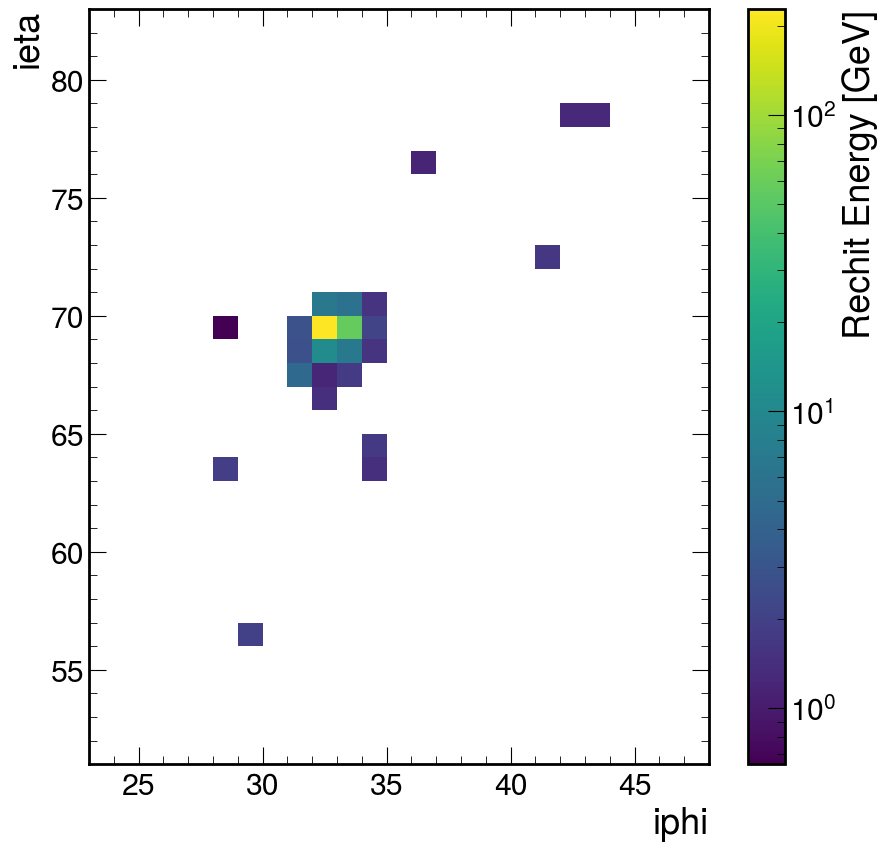

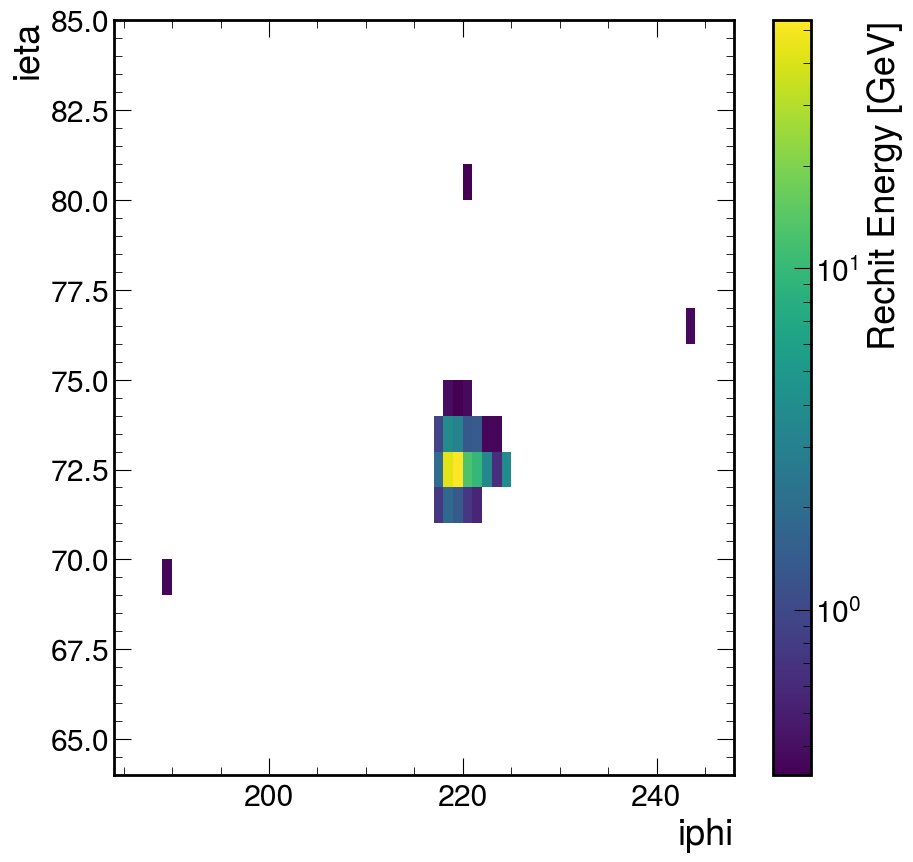

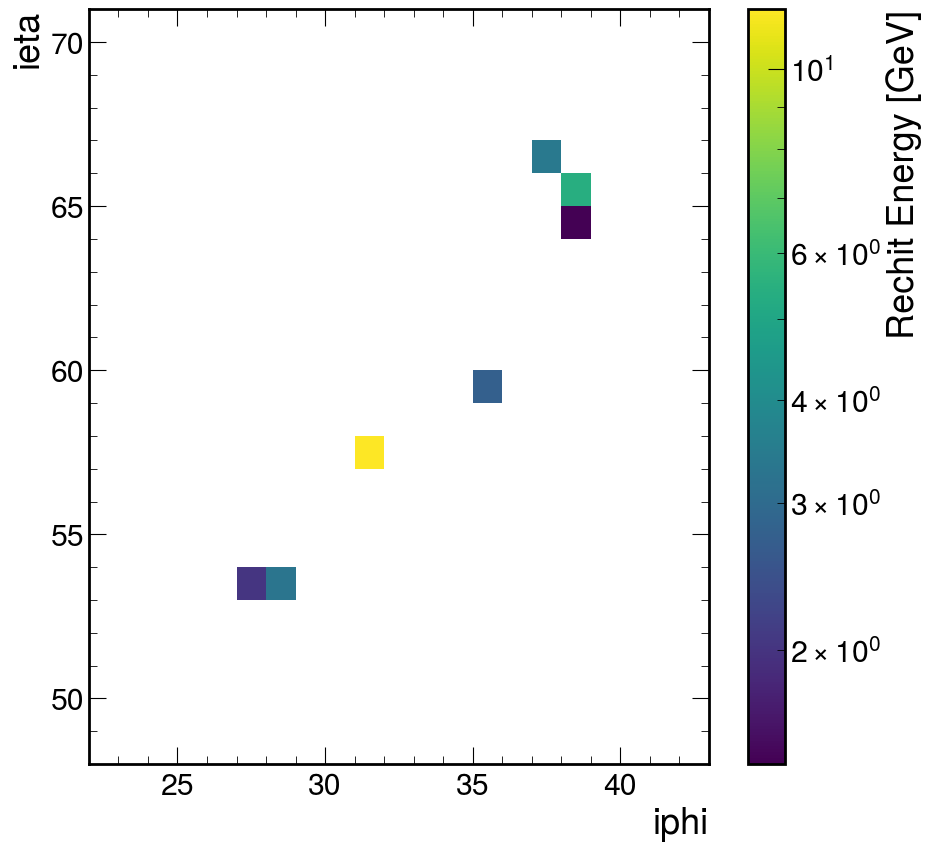

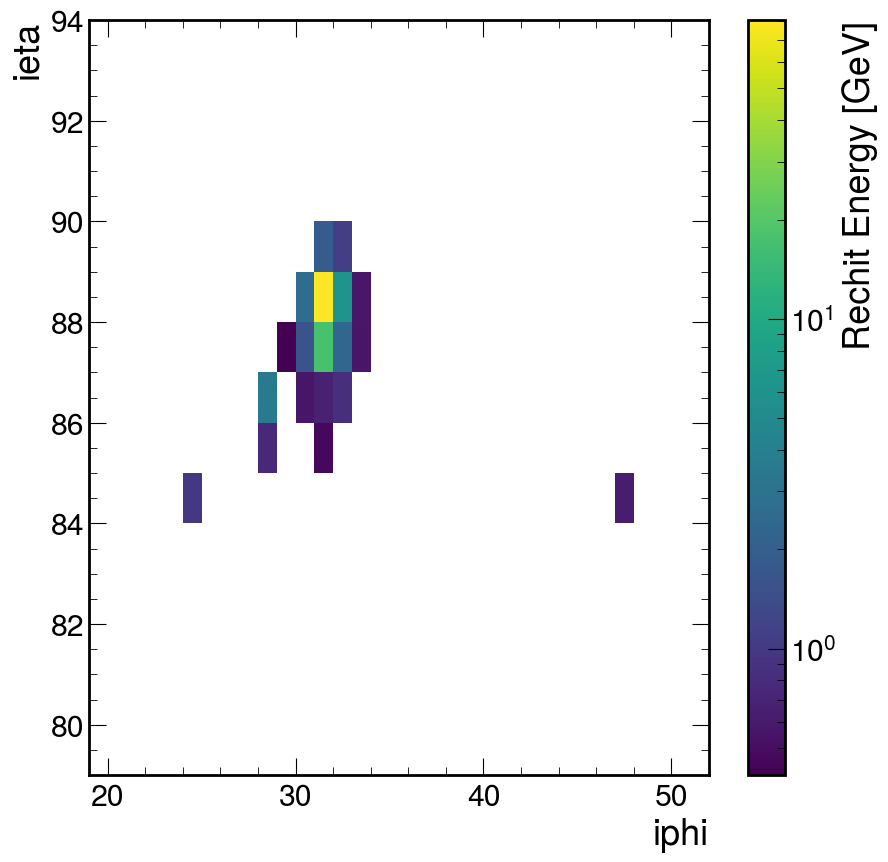

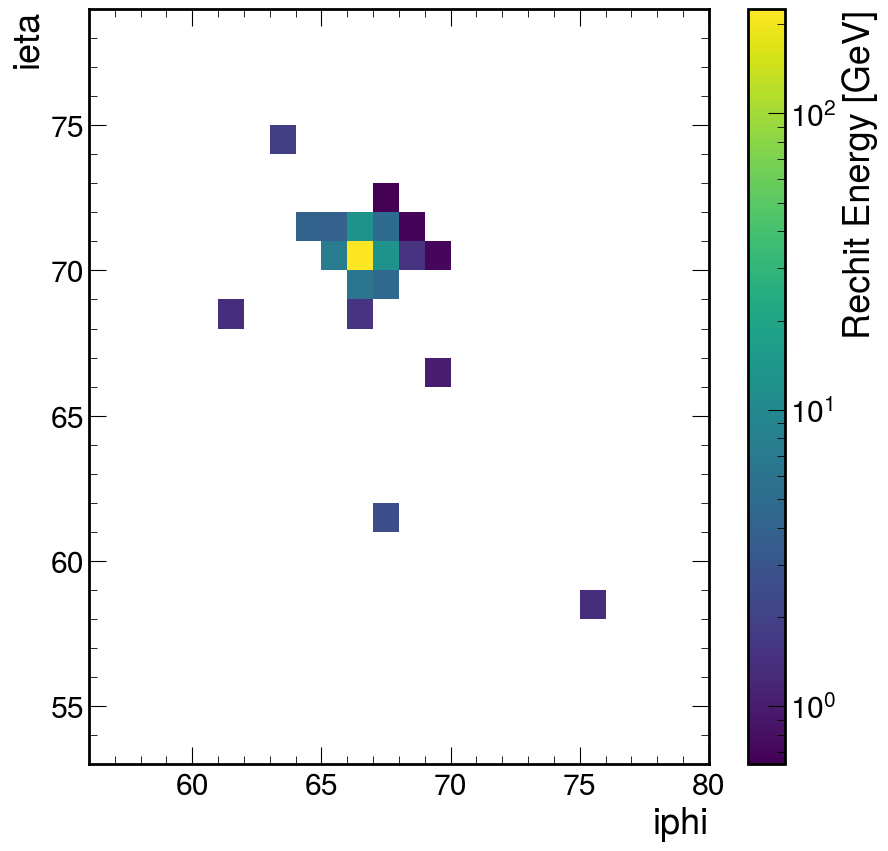

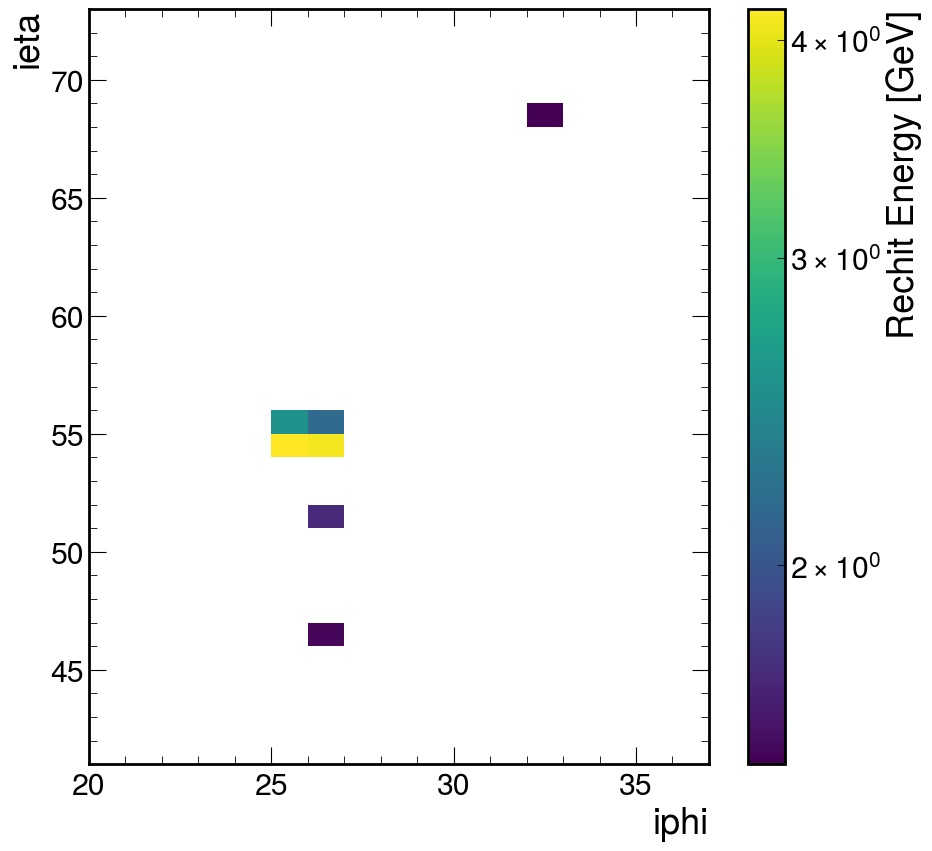

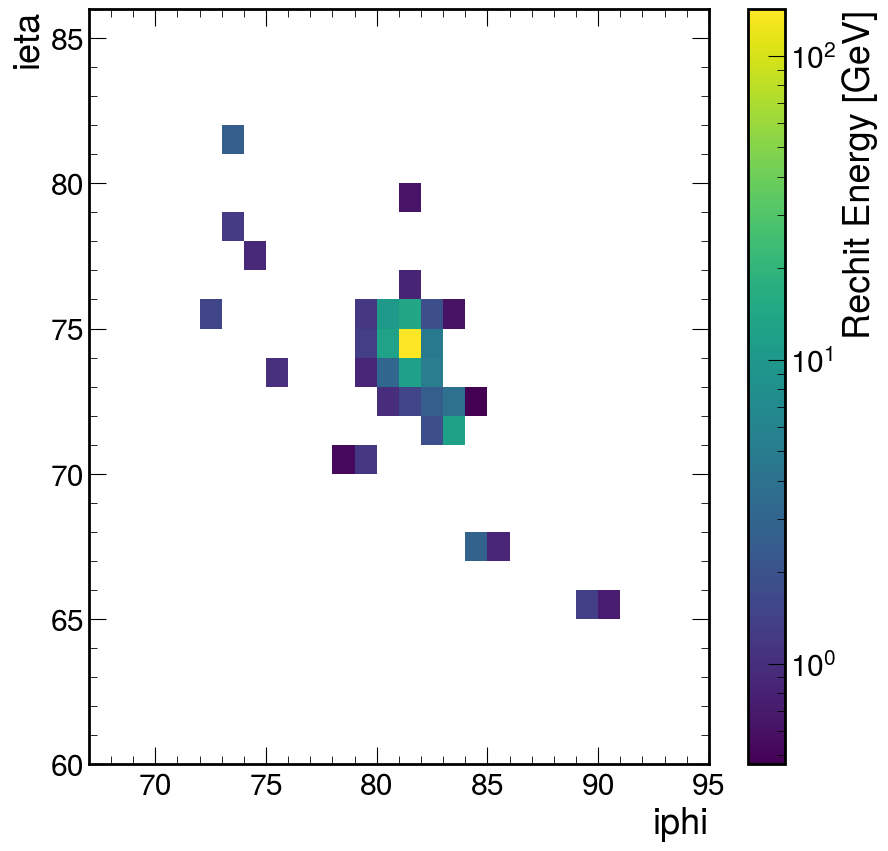

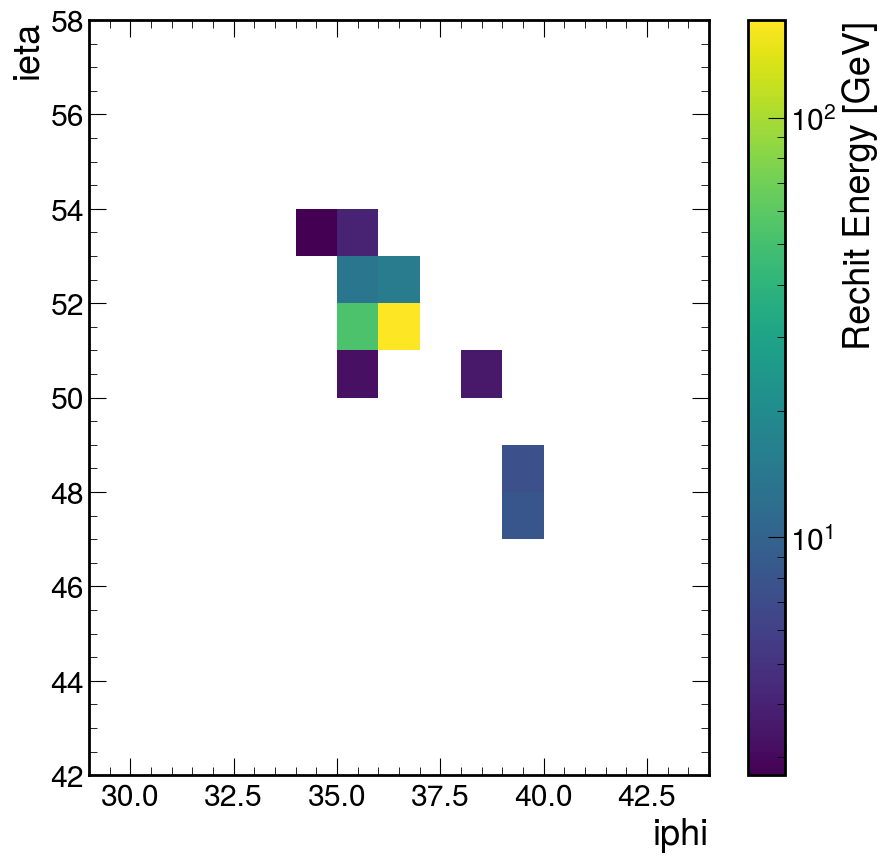

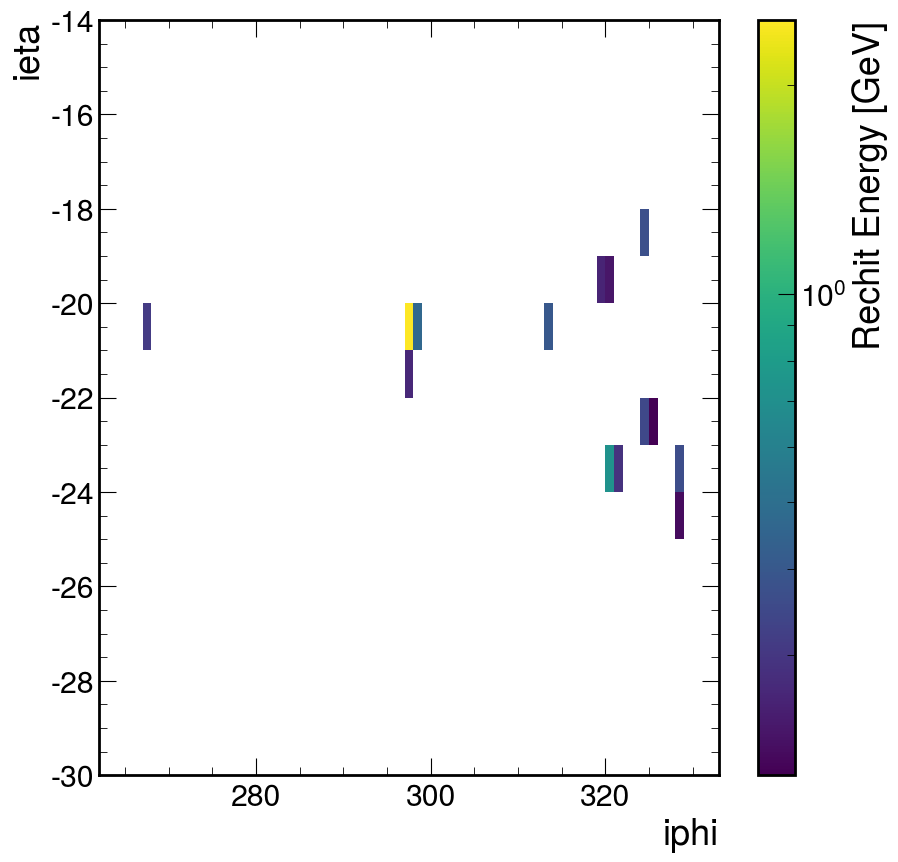

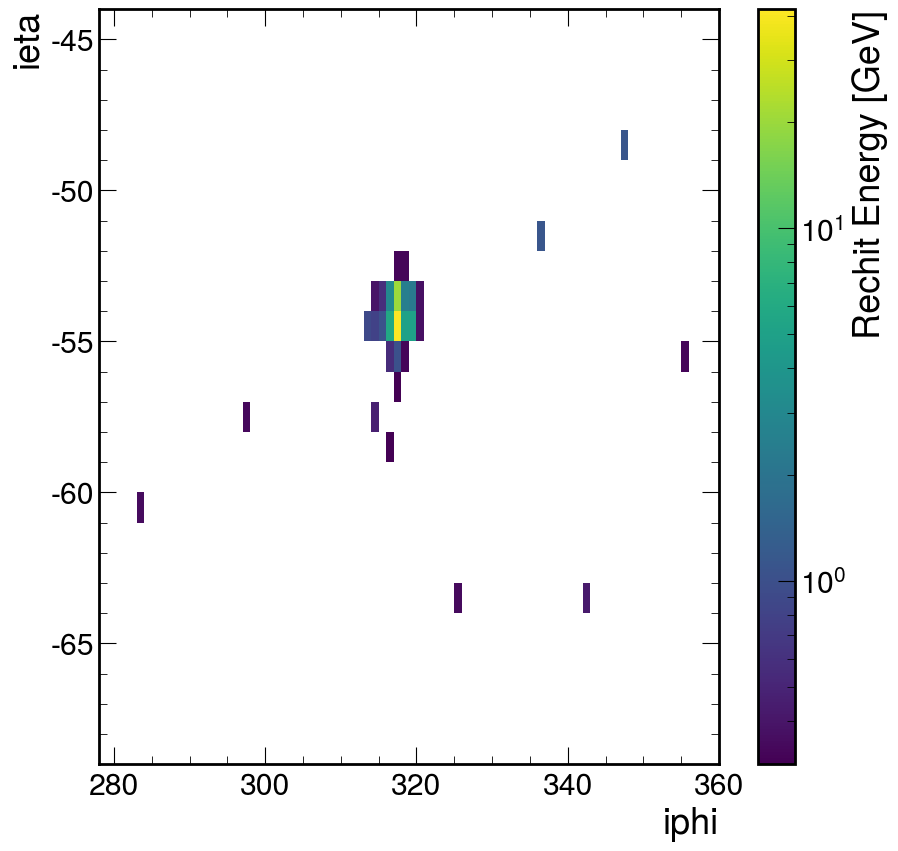

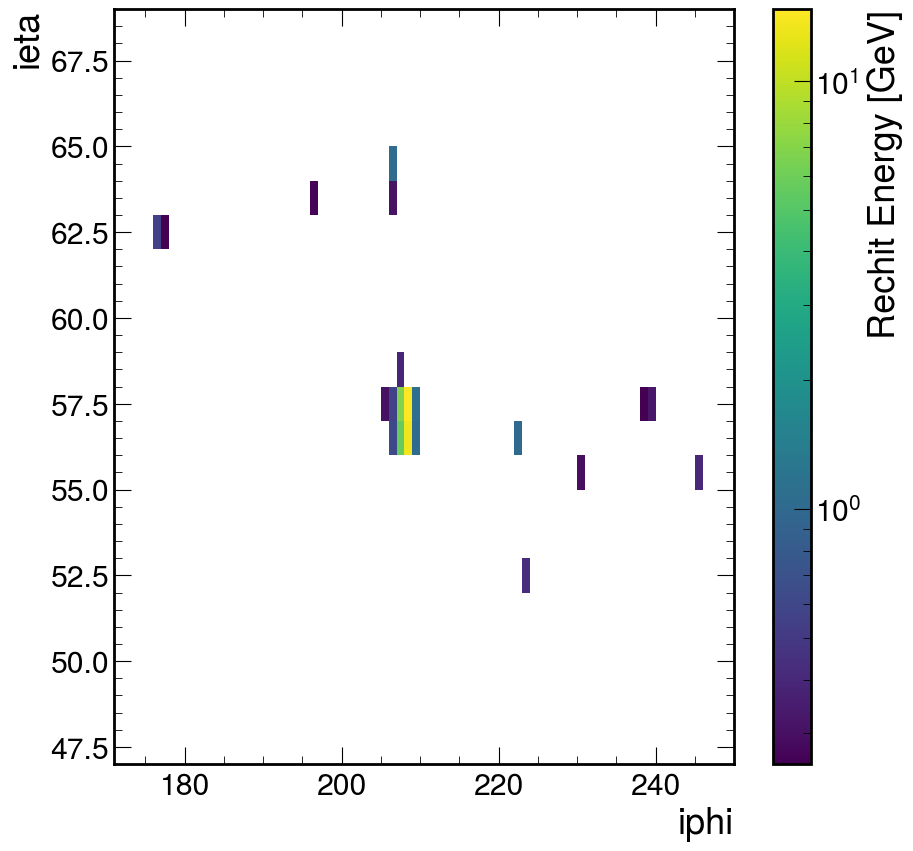

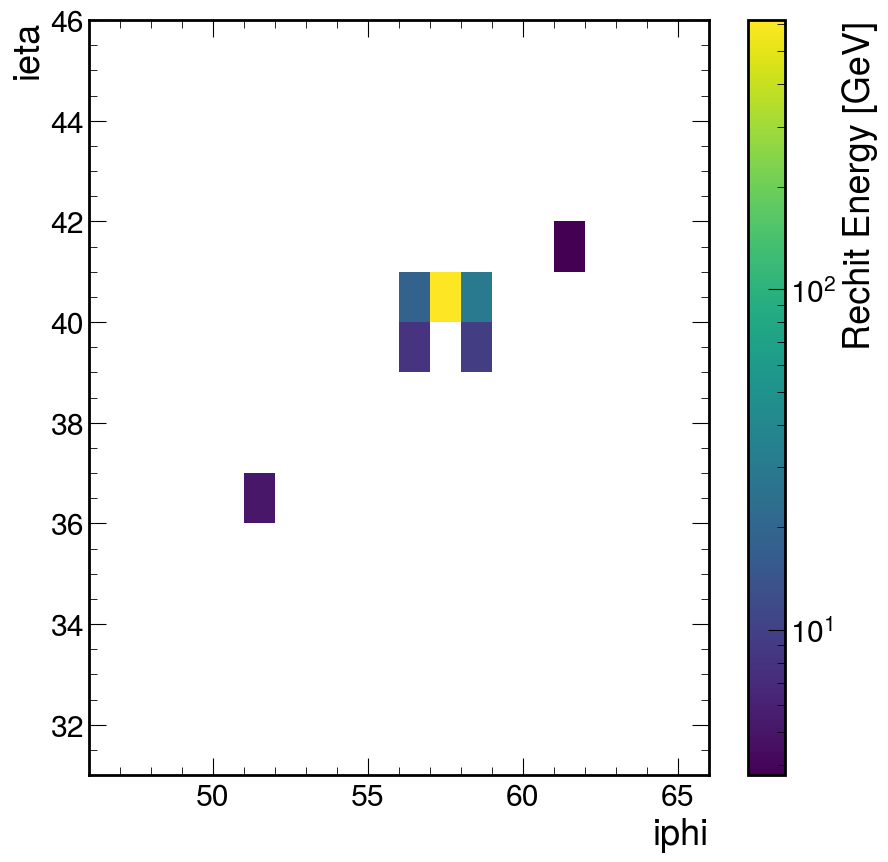

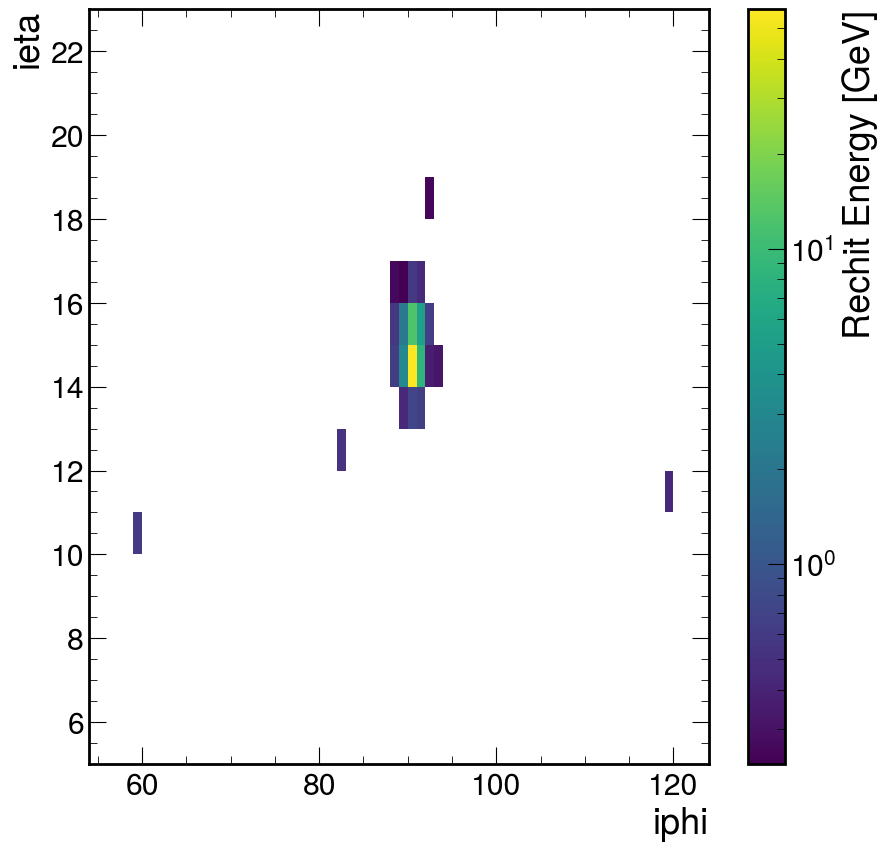

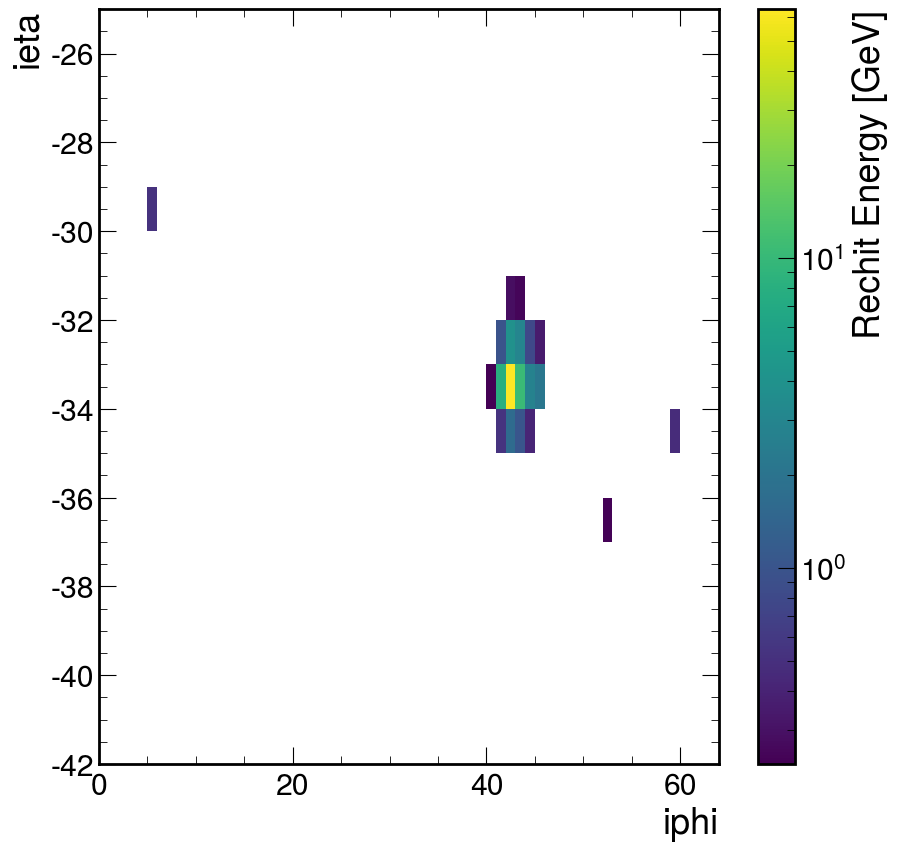

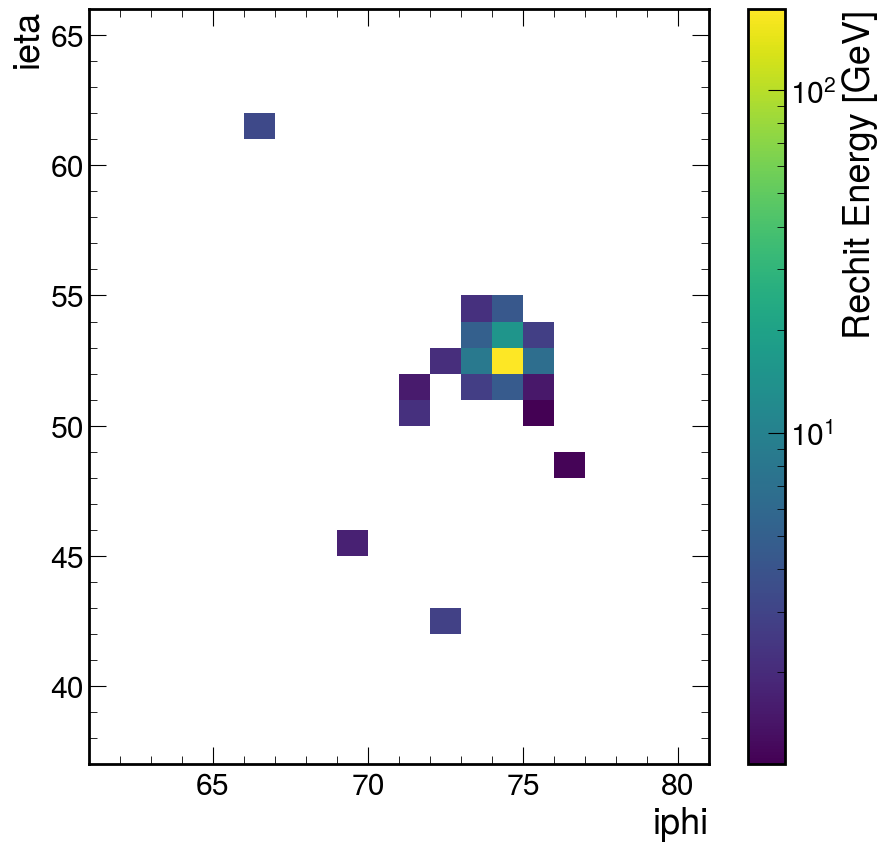

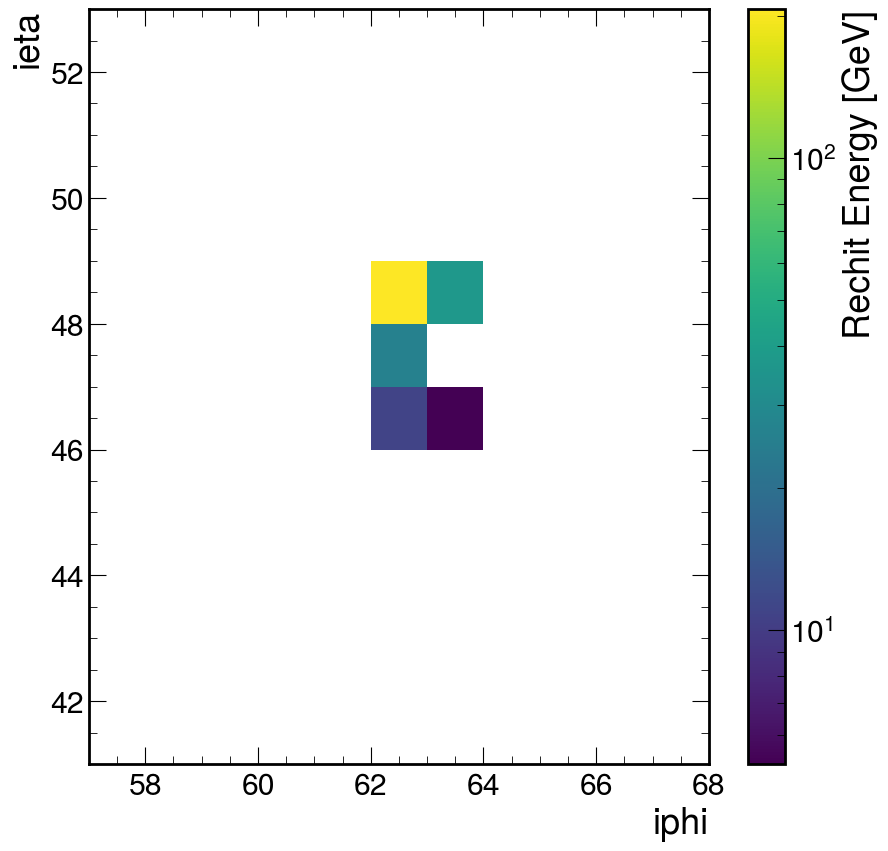

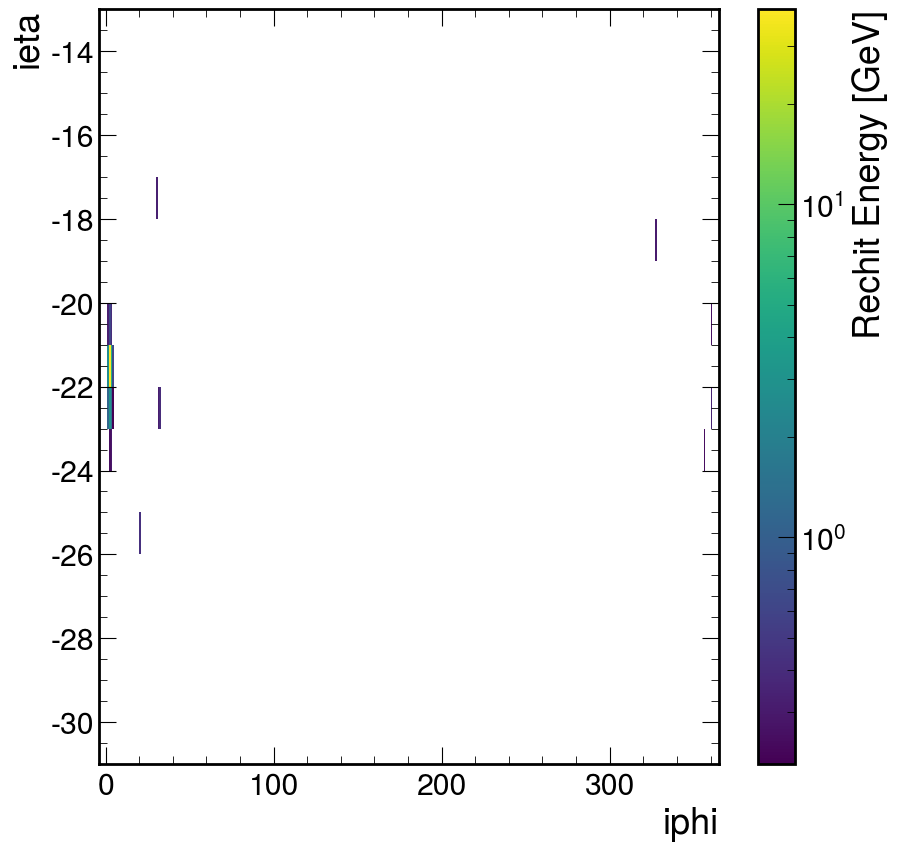

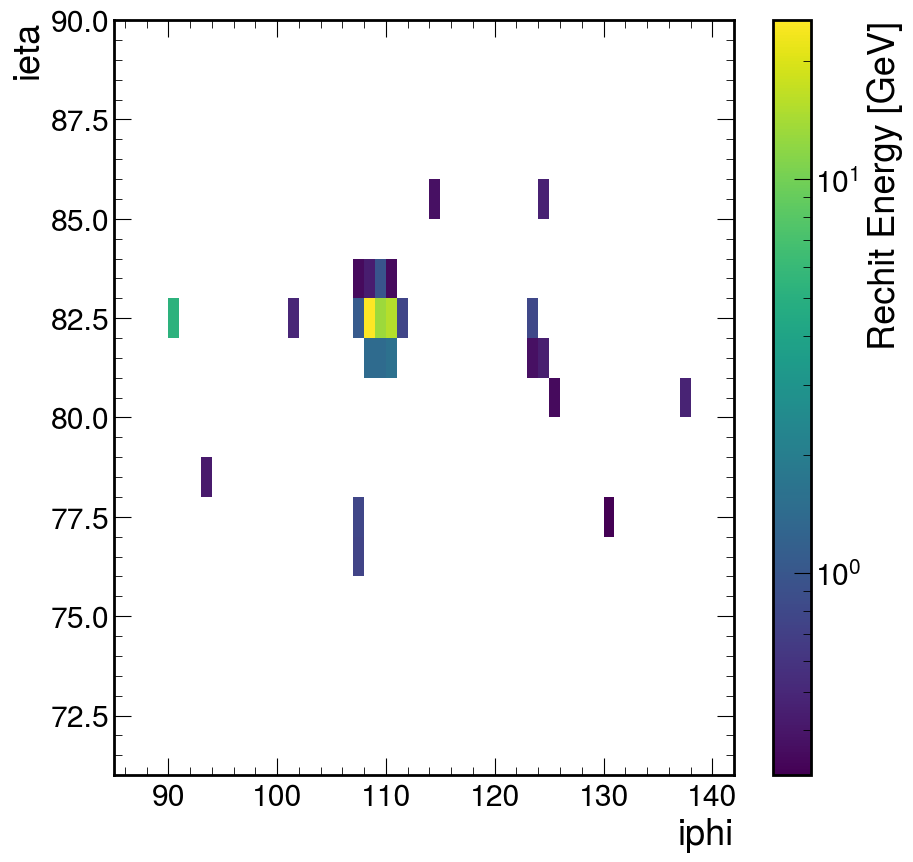

In [103]:
for i in range(50):
    plot_rechits(df.cl_h[i])

# Getting features and padding

In [6]:
default_features_dict = {
        "cl_features" : [ "en_cluster","et_cluster",
                        "cluster_eta", "cluster_phi", 
                        "cluster_ieta","cluster_iphi","cluster_iz",
                        "cluster_deta", "cluster_dphi",
                        "cluster_den_seed","cluster_det_seed",
                        "en_cluster_calib", "et_cluster_calib",
                        "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
                        "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
                        "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
                        "cl_sigmaIphiIphi","cl_swissCross",
                        "cl_nxtals", "cl_etaWidth","cl_phiWidth"],


    "cl_metadata": [ "calo_score", "calo_simen_sig", "calo_simen_PU",
                     "cluster_PUfrac","calo_nxtals_PU",
                     "noise_en","noise_en_uncal","noise_en_nofrac","noise_en_uncal_nofrac" ],

    "cl_labels" : ["is_seed","is_calo_matched","is_calo_seed", "in_scluster","in_geom_mustache","in_mustache"],

    
    "seed_features" : ["seed_eta","seed_phi", "seed_ieta","seed_iphi", "seed_iz", 
                     "en_seed", "et_seed","en_seed_calib","et_seed_calib",
                    "seed_f5_r9","seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi",
                    "seed_f5_sigmaIphiIphi","seed_f5_swissCross",
                    "seed_r9","seed_sigmaIetaIeta", "seed_sigmaIetaIphi",
                    "seed_sigmaIphiIphi","seed_swissCross",
                    "seed_nxtals","seed_etaWidth","seed_phiWidth"
                    ],

    "seed_metadata": [ "seed_score", "seed_simen_sig", "seed_simen_PU", "seed_PUfrac"],
    "seed_labels" : [ "is_seed_calo_matched", "is_seed_calo_seed", "is_seed_mustache_matched"],

     "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

    "window_metadata": ["ncls", "nclusters_insc",
                        "nVtx", "rho", "obsPU", "truePU",
                        "sim_true_eta", "sim_true_phi",  
                        "gen_true_eta","gen_true_phi",
                        "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                        "en_true_sim_good", "et_true_sim_good",
                        "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                        "max_en_cluster_insc","max_deta_cluster_insc","max_dphi_cluster_insc",
                        "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig"  ],
}

In [7]:
cl_x_f = ["en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "en_cluster_calib", "et_cluster_calib",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

cl_y_f = ["in_scluster", "is_seed"] 

### Tests

In [112]:
batch_size = 256

config = { "columns": {"cl_features": cl_x_f, 
                       "cl_labels":cl_y_f,
                      "window_metadata":["nVtx", "rho", "obsPU", "truePU","ncls","ncls", "nclusters_insc"] }, 
          "read_hits":True, 
          "ncls_padding" : -1, 
          "nhits_padding": -1
         }
initial_ele = load_dataset_chunks(df_ele, batch_size*20, 1500000, config)
initial_gamma = load_dataset_chunks(df_gamma, batch_size*20, 1500000, config)
tot = concat_datasets(initial_ele, initial_gamma)
#cache = buffer(tot, 10)
#tot_shuffle = shuffle_dataset(tot)
#final = split_batches(tot_shuffle, batch_size)
final = split_batches(tot, batch_size)

In [113]:
%%time
for i, (size, df) in enumerate(final):
    print(i, end=", ")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

# Multiprocessing generator

In [25]:
 def preprocessing(config):
    '''
    config must contains
    - ncls_padding
    - nhits_padding
    '''
    def process_fn(data): 
        size, df = data
        # Shuffle
        size, df = shuffle_fn(size, df)
        
        # Extraction of the ntuples and zero padding

        #padding
        if config["padding"]:
            if config["ncls_padding"] == -1:
                # dynamic padding
                max_ncls = ak.max(ak.num(df.cl_features, axis=1))
            else:
                max_ncls = config["ncls_padding"]
            if config["nhits_padding"] == -1:
                max_nhits = ak.max(ak.num(df.cl_h, axis=2))
            else:
                max_nhits = config["nhits_padding"]

            cls_X_pad = ak.pad_none(df.cl_features, max_ncls, clip=True)
            cls_Y_pad = ak.pad_none(df.cl_labels["in_scluster"], max_ncls, clip=True)
            is_seed_pad = ak.pad_none(df.cl_labels["is_seed"], max_ncls, clip=True)

            cls_X_pad = ak.fill_none(cls_X_pad, {k:0 for k in config["columns"]["cl_features"]})
            cls_Y_pad = ak.fill_none(cls_Y_pad, 0.)
            is_seed_pad = ak.fill_none(is_seed_pad, False)
            
            # hits padding
            h_padh = ak.pad_none(df.cl_h, max_nhits, axis=2) # --> pad rechits dim
            h_padh_padcl = ak.pad_none(h_padh, max_ncls, axis=1) # --> pad ncls dimension
            h_padh_padcl_fillnoneCL = ak.fill_none(h_padh_padcl, [None]*max_nhits, axis=1) #-- > fill the out dimension with None
            cl_hits_pad = np.asarray(ak.fill_none(h_padh_padcl_fillnoneCL, [0.,0.,0.,0.] , axis=2)) # --> fill the padded rechit dim with 0.
           
            cls_X_pad_n = np.transpose(np.asarray(ak.concatenate(ak.unzip(cls_X_pad[:, np.newaxis]), axis=1)),axes=(0,2,1))
            cls_Y_pad_n = np.transpose(np.asarray(ak.concatenate(ak.unzip(cls_Y_pad[:, np.newaxis]), axis=1)),axes=(0,2,1))
            is_seed_pad_n = np.asarray(is_seed_pad)
            

            return size, (cls_X_pad_n, cls_Y_pad_n, is_seed_pad_n)
        else:
            cls_X = df.cl_features, max_ncls
            cls_Y = df.cl_labels["in_scluster"], max_ncls
            is_seed = df.cl_labels["is_seed"], max_ncls
            cl_hits = df.cl_h
            return size, (cls_X, cls_Y, is_seed, cl_hits)
            
    return process_fn

In [13]:
batch_size = 512

config = { "columns": {"cl_features": cl_x_f, "cl_labels":cl_y_f}, 
          "padding" : True,
          "read_hits":True, 
          "ncls_padding" : -1, 
          "nhits_padding": -1
         }

initial_ele = load_dataset_chunks(df_ele, batch_size*30, 1500000, config)
initial_gamma = load_dataset_chunks(df_gamma, batch_size*30, 1500000, config)
ele_gamma = concat_datasets(initial_ele, initial_gamma)
preprocess_fn = preprocessing(config)

m = multiprocessor_generator(ele_gamma, preprocess_fn, 12, 10, nworkers=5)
final = split_batches(m, batch_size)

In [12]:
m.close()

In [14]:
%%time
for i, (size, df) in enumerate(final):
    print(i, end=", ")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [26]:
batch_size = 512

config = { "columns": {"cl_features": cl_x_f, "cl_labels":cl_y_f}, 
          "padding" : True,
          "read_hits":True, 
          "ncls_padding" : -1, 
          "nhits_padding": -1
         }
initial_ele = load_dataset_chunks(df_ele, batch_size*20, 1500000, config)
initial_gamma = load_dataset_chunks(df_gamma, batch_size*20, 1500000, config)
tot = concat_datasets(initial_ele, initial_gamma)
preprocess_fn = preprocessing(config)
proc_single = (preprocess_fn(p) for p in tot)
#m = multiprocessor_generator(ele_gamma, preprocess_fn, 12, 10, nworkers=5)
final = split_batches(proc_single, batch_size)

In [27]:
%%time
for i, (size, df) in enumerate(final):
    print(i, end=", ")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 

KeyboardInterrupt: 

In [22]:
d = next(tot)

In [27]:
preprocess_fn(d)

(2560,
 (array([[[ 9.10397949e+01,  4.93329620e+01, -1.22271633e+00, ...,
            1.70000000e+01,  8.54171161e-03,  1.03630899e-02],
          [ 9.33674145e+00,  5.04292541e+00, -1.22660053e+00, ...,
            1.40000000e+01,  9.29480791e-03,  1.07410382e-02],
          [ 5.57105005e-01,  2.81735860e-01, -1.30381143e+00, ...,
            1.00000000e+00,  2.38542468e-03,  1.32298470e-03],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
  
         [[ 8.99980850e+01,  7.92656235e+01, -5.14682353e-01, ...,
            1.40000000e+01,  1.09300418e-02,  8.81186593e-03],
          [ 2.74424314e-01,  2.46584123e-01, -4.70830381e-01, ..

In [18]:
%load_ext snakeviz

In [24]:
%time 
preprocess_fn(d)


CPU times: user 1e+03 ns, sys: 5 µs, total: 6 µs
Wall time: 14.3 µs


(20480,
 (array([[[ 2.82783175e+00,  2.31914977e+00, -6.50783896e-01, ...,
            4.00000000e+00,  9.54679679e-03,  7.41302921e-03],
          [ 5.14256775e-01,  4.31916894e-01, -6.08064711e-01, ...,
            1.00000000e+00,  2.30687554e-03,  1.90043449e-03],
          [ 4.64771867e-01,  3.86708718e-01, -6.25167727e-01, ...,
            1.00000000e+00,  2.26206006e-03,  1.90806389e-03],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
  
         [[ 4.58101959e+01,  7.45720808e+00,  2.50178123e+00, ...,
            1.00000000e+01,  4.56475876e-02,  3.76401246e-02],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, .

In [23]:
%%snakeviz 

preprocess_fn(d)

 
*** Profile stats marshalled to file '/tmp/tmpuh5kemax'.
Embedding SnakeViz in this document...
